### 5.1 Introduction to convnets

先用convnet搭一个LeNet5在MNIST跑一下，看看和之前两层Dense的结果有何区别(精度约97.8%)：

In [1]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

C:\Users\10750\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 64)          36928     
Total params: 55,744
Trainable params: 55,744
Non-trainable params: 0
_________________________________________________________________


In [3]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                36928     
__________

In [4]:
from keras.datasets import mnist
from keras.utils import to_categorical

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(train_images, train_labels, epochs=5, batch_size=64)

Epoch 1/5
60000/60000 [==============================] - 42s 701us/step - loss: 0.1666 - acc: 0.9484
Epoch 2/5
60000/60000 [==============================] - 14s 237us/step - loss: 0.0466 - acc: 0.98570s - loss: 0.0468 - acc: 0.9
Epoch 3/5
60000/60000 [==============================] - 14s 235us/step - loss: 0.0315 - acc: 0.99021s -  - ETA: 0s - loss: 0.0314 - acc: 0.990
Epoch 4/5
60000/60000 [==============================] - 14s 235us/step - loss: 0.0240 - acc: 0.99290s - loss: 0.0242 - 
Epoch 5/5
60000/60000 [==============================] - 15s 246us/step - loss: 0.0189 - acc: 0.9943


In [5]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

10000/10000 [==============================] - 2s 167us/step


In [6]:
test_acc

0.9895

之所以使用convnet得到的结果要更好，是因为其性质和视觉空间的以下两个性质相契合：
- 卷积神经网络学到的模式具有平移不变性
- 卷积神经网络可以学到模式的空间层次(每一层feature map的表示抽象程度提高，这也是采用pooling做下采样的重要原因)

### 5.2 Training a convnet from scratch on a small dataset

这一节我们从原始数据集训练一个模型来做二分类。使用的是kaggle上cat-vs-dog比赛数据集的一个子集。因为我们只用4000张图像，其中2000张用于训练，1000张用于验证，1000张用于测试，这个数据体量是很容易过拟合的。因此这一节中我们采用data augmentation对图像进行处理。

In [9]:
import os, shutil

original_dataset_dir = r'C:\Users\10750\Desktop\notebook\datasets\catvsdog\train'

base_dir = r'C:\Users\10750\Desktop\notebook\datasets\catvsdog\dataset_4000'
os.mkdir(base_dir)

train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)
test_dir = os.path.join(base_dir,'test')
os.mkdir(test_dir)

train_cats_dir = os.path.join(train_dir, 'cats')
os.mkdir(train_cats_dir)
train_dogs_dir = os.path.join(train_dir, 'dogs')
os.mkdir(train_dogs_dir)

validation_cats_dir = os.path.join(validation_dir, 'cats')
os.mkdir(validation_cats_dir)
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
os.mkdir(validation_dogs_dir)

test_cats_dir = os.path.join(test_dir, 'cats')
os.mkdir(test_cats_dir)
test_dogs_dir = os.path.join(test_dir, 'dogs')
os.mkdir(test_dogs_dir)

fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_cats_dir, fname)
    shutil.copyfile(src, dst)
    
fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_cats_dir, fname)
    shutil.copyfile(src, dst)
    
fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dogs_dir, fname)
    shutil.copyfile(src, dst)

In [12]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                       input_shape=(150, 150, 3)))
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3),activation='relu'))
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 15, 15, 128)       147584    
__________

In [15]:
from keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

在把数据feed到模型中前，我们要先对数据进行预处理，将JPEG格式的数据处理为浮点型张量的格式。具体步骤如下:

1. 读取图像文件
2. 将JPEG文件解码为RGB grids
3. 将RGB grids转换为浮点数张量
4. 将像素值缩放到[0, 1]区间

Keras有着自动完成这些步骤的工具。keras.preprocessing.image中有一个图像处理辅助工具的模块。ImageDataGenerator可以快速创建python生成器，将硬盘上的图像文件自动处理为preprocessed张量batch。

In [17]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

# class由不同train_dir下不同dir名称决定
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [18]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)


In [19]:
# fit_generator方法适用于要fit的数据在磁盘而非内存上，并采用
# generator生成数据，其可以在generator上fit数据
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/30
100/100 [==============================] - 97s 971ms/step - loss: 0.6891 - acc: 0.5365 - val_loss: 0.6973 - val_acc: 0.5000
Epoch 2/30
100/100 [==============================] - 42s 423ms/step - loss: 0.6622 - acc: 0.6055 - val_loss: 0.6779 - val_acc: 0.5540
Epoch 3/30
100/100 [==============================] - 90s 904ms/step - loss: 0.6353 - acc: 0.6500 - val_loss: 0.6354 - val_acc: 0.6330
Epoch 4/30
100/100 [==============================] - 40s 401ms/step - loss: 0.5923 - acc: 0.6835 - val_loss: 0.6353 - val_acc: 0.6300
Epoch 5/30
100/100 [==============================] - 23s 225ms/step - loss: 0.5494 - acc: 0.7225 - val_loss: 0.5929 - val_acc: 0.6710
Epoch 6/30
100/100 [==============================] - 19s 188ms/step - loss: 0.5208 - acc: 0.7345 - val_loss: 0.5877 - val_acc: 0.6810
Epoch 7/30
100/100 [==============================] - 18s 183ms/step - loss: 0.4880 - acc: 0.7645 - val_loss: 0.5742 - val_acc: 0.6970
Epoch 8/30
100/100 [==============================] - 1

In [20]:
model.save('cats_and_dogs_small_1.h5')

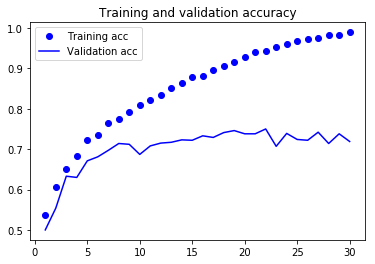

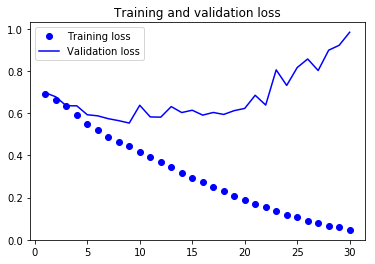

In [21]:
# 绘制loss和acc曲线
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

从以上曲线中可以明显看出过拟合的情况，这是由于学习样本的数目过少。下面我们用Keras中的ImageDataGenerator做数据增强：

In [22]:
datagen = ImageDataGenerator(
    rotation_range=40,         # 图像随机旋转的角度值
    width_shift_range=0.2,     # 图像在水平方向上平移的范围
    height_shift_range=0.2,    # 图像在竖直方向上平移的范围
    shear_range=0.2,           # 随机错切变换的角度
    zoom_range=0.2,            # 随机缩放的范围
    horizontal_flip=True,      # 随机将一半图像水平翻转
    fill_mode='nearest')       # 填充新像素的方法

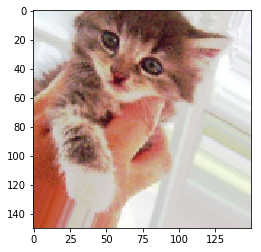

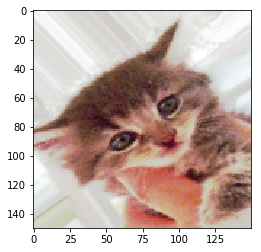

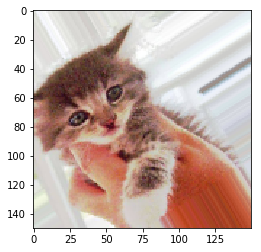

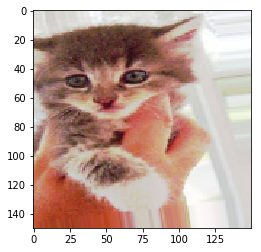

In [23]:
from keras.preprocessing import image

fnames = [os.path.join(train_cats_dir, fname) for
         fname in os.listdir(train_cats_dir)]

img_path = fnames[3]

img = image.load_img(img_path, target_size=(150, 150))

x = image.img_to_array(img)

x = x.reshape((1, ) + x.shape)

i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgpolt = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i%4 == 0:
        break
plt.show()

In [25]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
            input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
    optimizer=optimizers.RMSprop(lr=1e-4),
    metrics=['acc'])

In [26]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

In [27]:
# 不能对验证集做augmentation
test_datagen = ImageDataGenerator(rescale=1./255)

In [28]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150,150),
    batch_size=32,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/100
100/100 [==============================] - 120s 1s/step - loss: 0.6937 - acc: 0.5078 - val_loss: 0.6813 - val_acc: 0.5470
Epoch 2/100
100/100 [==============================] - 48s 480ms/step - loss: 0.6840 - acc: 0.5634 - val_loss: 0.6709 - val_acc: 0.5480
Epoch 3/100
100/100 [==============================] - 58s 578ms/step - loss: 0.6699 - acc: 0.5888 - val_loss: 0.6591 - val_acc: 0.5860
Epoch 4/100
100/100 [==============================] - 47s 468ms/step - loss: 0.6593 - acc: 0.5994 - val_loss: 0.6476 - val_acc: 0.6080
Epoch 5/100
100/100 [==============================] - 44s 436ms/step - loss: 0.6430 - acc: 0.6253 - val_loss: 0.6513 - val_acc: 0.6060
Epoch 6/100
100/100 [==============================] - 42s 421ms/step - loss: 0.6279 - acc: 0.6566 - val_loss: 0.6122 - val_acc: 0.6530
Epoch 7/100
100/100 [==============================] - 44s 440ms/step - loss: 0.6182 - acc: 0.6606 - v

In [29]:
model.save('cats_and_dogs_small_2.h5')

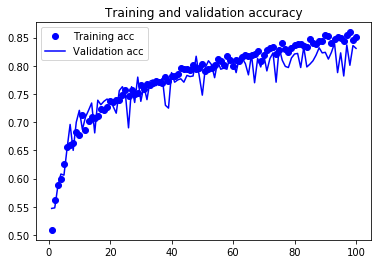

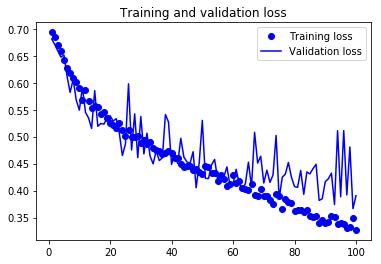

In [30]:
# 绘制loss和acc曲线
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### 5.3 Using a pretrained convnet

想要将深度学习应用于小型图像数据集，一种常用且非常高效的方法是使用预训练网络。预训练网络（pretrained network）是一个保存好的网络，之前已在大型数据集（通常是大规模图像分类任务）上训练好。如果这个原始数据集足够大且足够通用，那么**预训练网络学到的特征的空间层次结构可以有效地作为视觉世界的通用模型**，因此这些特征可用于各种不同的计算机视觉问题，即使这些新问题涉及的类别和原始任务完全不同。

这种学到的特征在不同问题之间的可移植性，是深度学习相比早期浅层学习方法的重要优势，它使得深度学习对小数据问题非常有效。

使用pretrained network有以下两种方法: feature extraction特征提取和fine-tuning微调模型。

#### 5.3.1 Feature extraction
所谓特征提取，即复用预训练模型中的convolutional base，在其feature map后重新训练一个新的分类器(Dense层的连接)。之所以这么做是因为convoltional layer学到的表示要更加通用。

下面我们从keras.applications中导入VGG16，并在其基础上训练一个新的模型：

In [1]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False, 
                  input_shape=(150, 150, 3))

C:\Users\10750\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


- weights是指定模型初始化的权重checkpoints
- include_top指定模型后是否包含原本的Dense分类层。默认情况下对应了ImageNet的1000个类别。
- input_shape可以调整任意输入的shape

In [2]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

可以从模型的summary中看出，最后的feature map的shape是(4, 4, 512)，我们可以在这一特征基础上添加一个Dense的分类器。

我们有两种方法添加这一分类器：
- 先在数据集上运行conv_base，将处理后训练数据的feature map保存为Numpy array再用这个数据去输入到一个新的独立的Dense分类器中。这种方法计算代价较低，但无法使用data augmentation。
- 在conv_base基础上再添加Dense层来扩展已有模型，并在输入数据上端到端的运行整个模型。这样可以使用数据增强，但计算代价比前一种要高很多。

In [3]:
# Fast feature extraction without data augmentation
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = r'C:\Users\10750\Desktop\notebook\datasets\catvsdog\dataset_4000'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i+1) * batch_size] = features_batch
        labels[i * batch_size : (i+1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [4]:
train_features = np.reshape(train_features, (2000, 8192))
validation_features = np.reshape(validation_features, (1000, 8192))
test_features = np.reshape(test_features, (1000, 8192))

In [5]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4*4*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 9s 4ms/step - loss: 0.6106 - acc: 0.6665 - val_loss: 0.4472 - val_acc: 0.8230
Epoch 2/30
2000/2000 [==============================] - 2s 1ms/step - loss: 0.4366 - acc: 0.8005 - val_loss: 0.3675 - val_acc: 0.8480- loss: 0.4419 - acc: 0.80 - ETA: 0s - loss: 0.4420 - acc: 
Epoch 3/30
2000/2000 [==============================] - 2s 1ms/step - loss: 0.3620 - acc: 0.8375 - val_loss: 0.3221 - val_acc: 0.88100s - loss: 0.3721 - acc: 0.831 - ETA: 0s - loss: 0.3725 - 
Epoch 4/30
2000/2000 [==============================] - 2s 1ms/step - loss: 0.3289 - acc: 0.8600 - val_loss: 0.2986 - val_acc: 0.8890
Epoch 5/30
2000/2000 [==============================] - 2s 1ms/step - loss: 0.2896 - acc: 0.8875 - val_loss: 0.2889 - val_acc: 0.8920: 1s - lo
Epoch 6/30
2000/2000 [==============================] - 3s 1ms/step - loss: 0.2690 - acc: 0.8895 - val_loss: 0.2720 - val_acc: 0.8970
Epoch 7/30
2000/2000 [

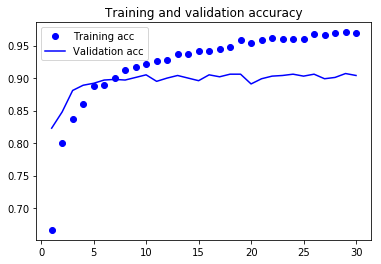

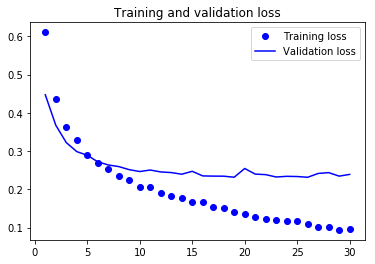

In [6]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

下面我们尝试另一种方法，即在conv_base上加一个Dense分类器，使得训练过程可以在完整的网络上进行。这一方法需要计算资源较大，故不跑实际的fit过程了。

In [7]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


在这种应用场景下，编译和训练模型之前一定要freeze冻结conv_base。也就是说，需要让卷积层的weights在训练过程中保持不变。

conv_base.trainable = False
model.compile(...)

#### 5.3.2 Fine-tuning

fine-tuning是指将在feature extraction中冻结的conv_base的顶部几层“解冻”，并将这解冻的几层和新增加的Dense分类器联合训练。之所以叫“fine-tuning”，是因为它知识略微调整了所复用模型中更加抽象的表示，以便让这些表示与手头的问题更加相关。

我们需要注意的是，在训练好conv_base上的Dense分类器后，才能fine-tuning conv_base的顶部几层。如果分类器没有训练好，那么训练期间通过网络传播的误差信号会特别大，微调的基层之前学到的表示都会被破坏，因此fine-tuning的步骤如下：
1. 在已经训练好的base network上添加自定义网络
2. 冻结base network
3. 训练所添加的部分
4. 解冻base network的一些层
5. 联合训练解冻的这些层和添加的部分

### 5.4 Visualizing what convnets learn

很多人说深度学习是“black box”，即模型学到的表示很难用人类可理解的方式来提取和呈现，但对于convnets而言绝非如此。convnets学到的表示非常适合可视化，很大程度上是因为它们是**视觉概念的表示**。

本节将介绍三种最容易理解的方法：
- Visualizing intermediate convnet outputs，可视化中间的激活结果
- Visualizing convnets filters，可视化filter的视觉模式
- Visualizing heatmaps of class activation in an image，可视化分类中的热力图

#### 5.4.1 Visualizing intermediate activations

可视化中间的激活结果，是指对于给定输入，展示网络中各个卷积层和池化层输出的**feature map**。由于每个像素通道都对应相对独立的特征，因此应该将每个通道的内容都绘制为二维图像进行可视化。

In [9]:
from keras.models import load_model
model = load_model('cats_and_dogs_small_2.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 15, 15, 128)       147584    
__________

In [16]:
img_path = r'C:\Users\10750\Desktop\notebook\datasets\catvsdog\dataset_4000\test\cats\cat.1700.jpg'
from keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size = (150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

print(img_tensor.shape)

(1, 150, 150, 3)


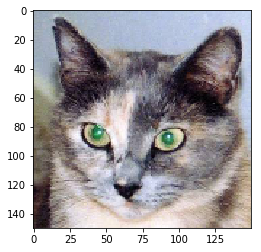

In [17]:
import matplotlib.pyplot as plt

plt.imshow(img_tensor[0])
plt.show()

我们需要的模型要以图像张量作为输入，model中所有卷积层与池化层的activations作为输出。为此需要使用keras中的Model类，其允许模型有多个输出：

In [18]:
from keras import models

layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [19]:
activations = activation_model.predict(img_tensor)

In [20]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 148, 148, 32)


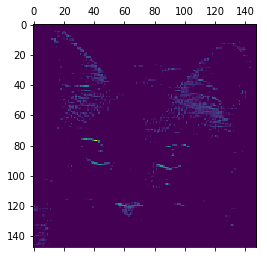

In [21]:
import matplotlib.pyplot as plt
plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')

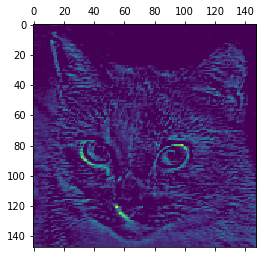

In [30]:
plt.matshow(first_layer_activation[0, :, :, 7], cmap='viridis')

C:\Users\10750\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
C:\Users\10750\Anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


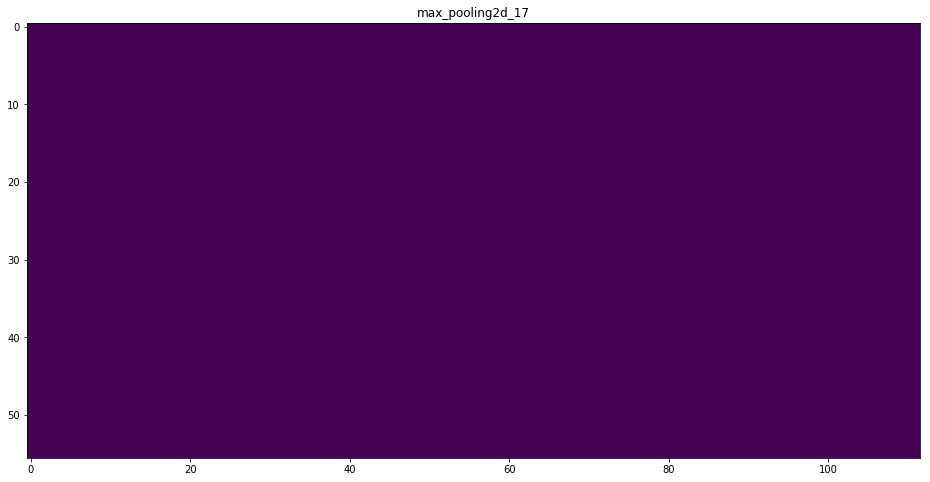

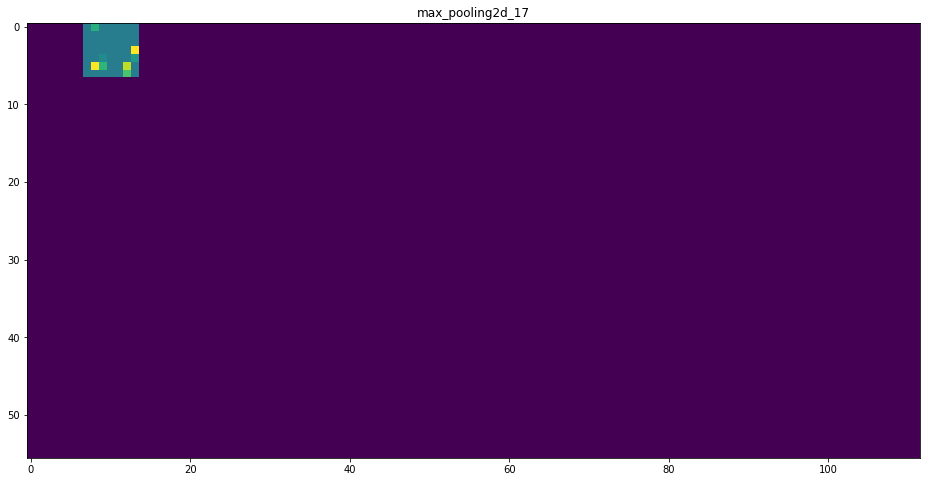

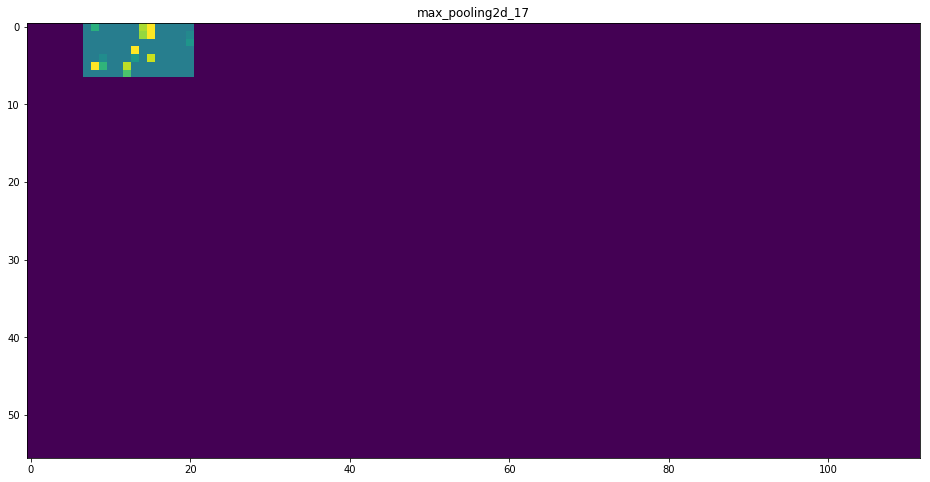

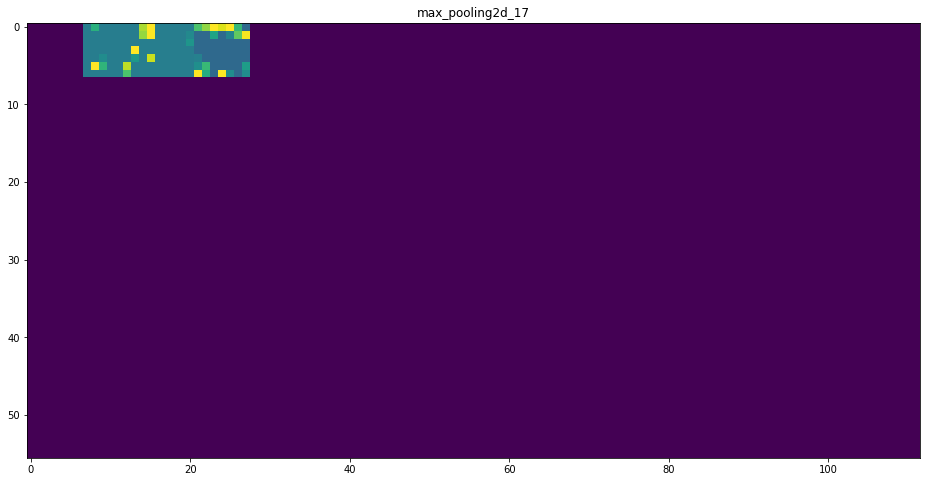

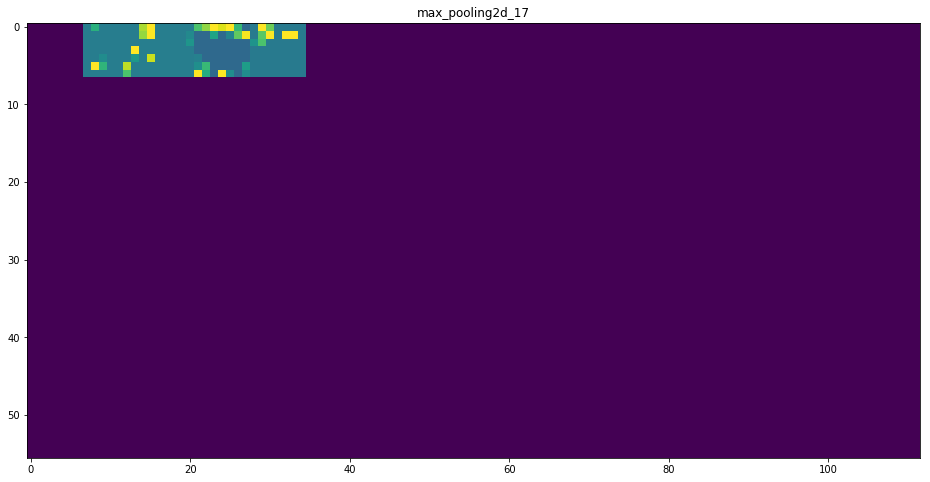

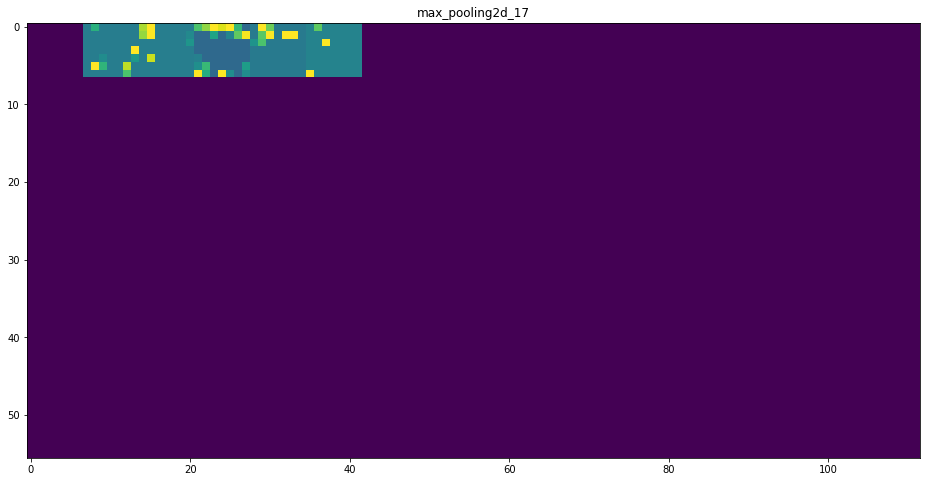

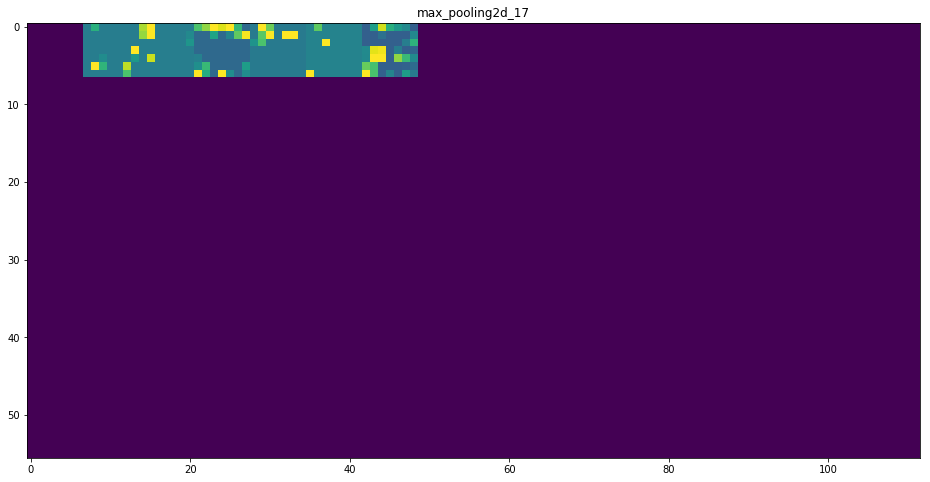

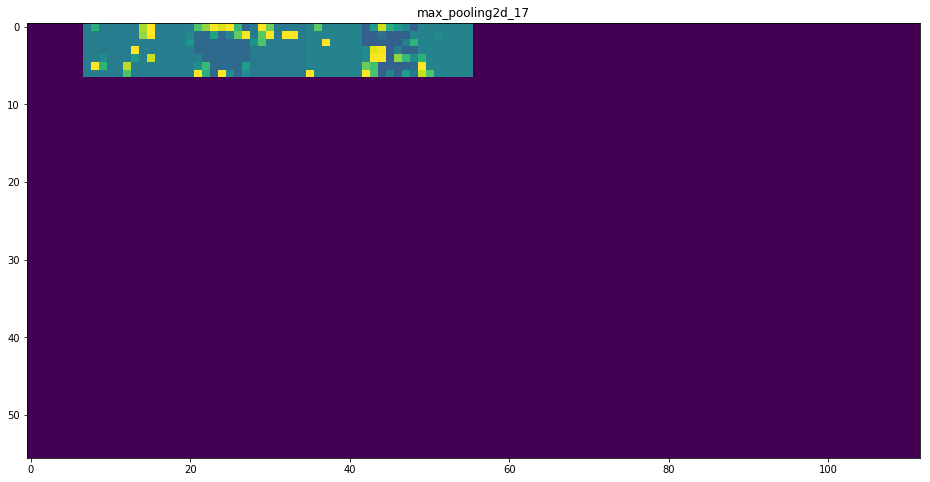

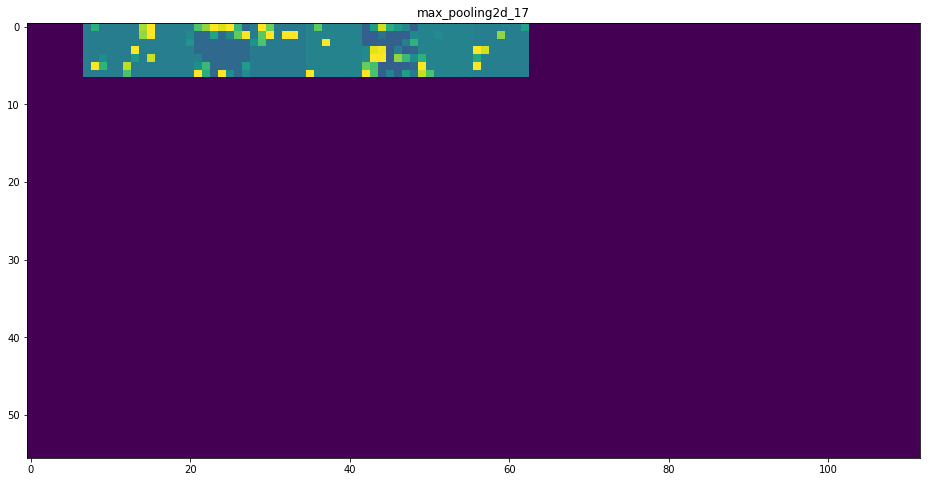

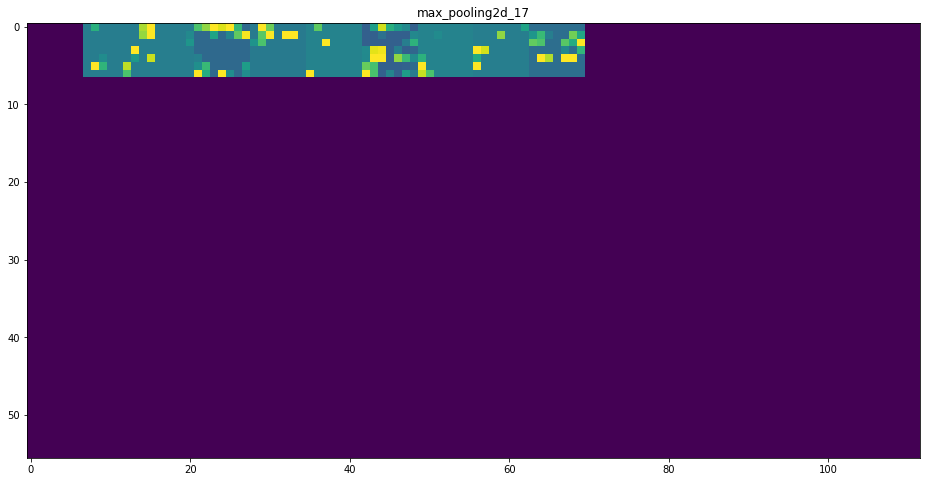

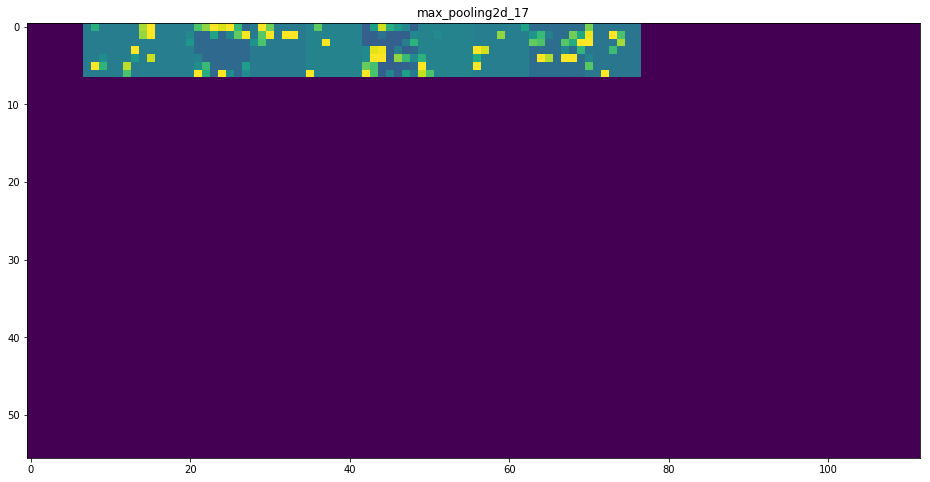

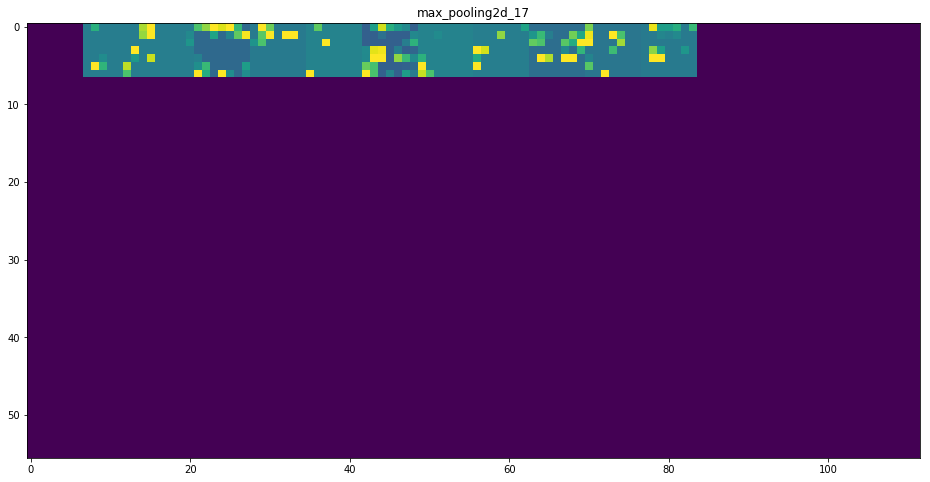

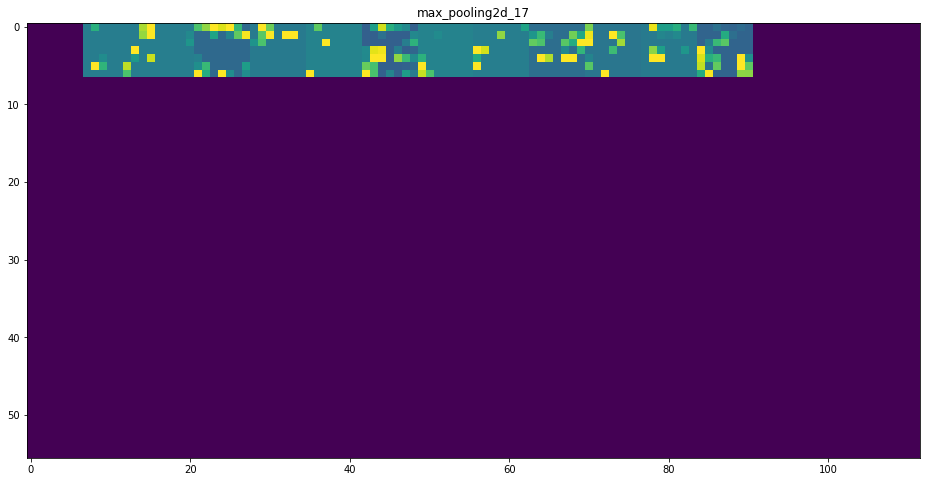

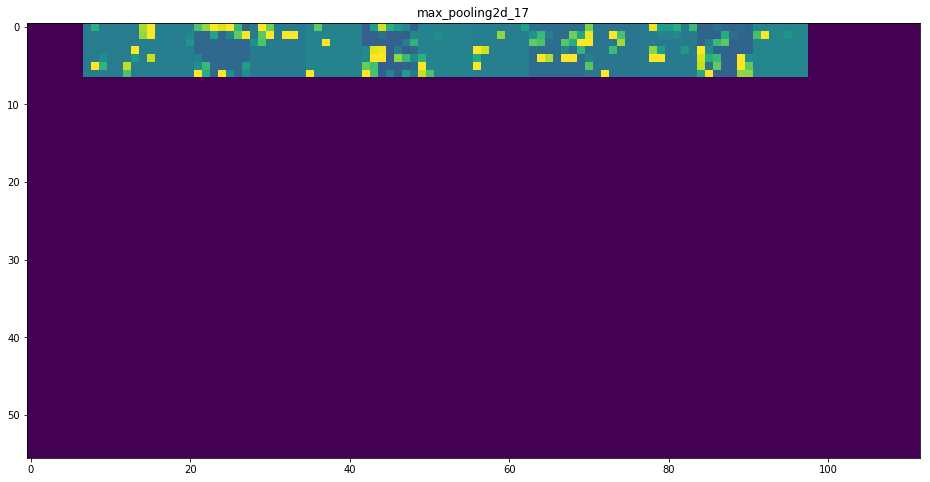

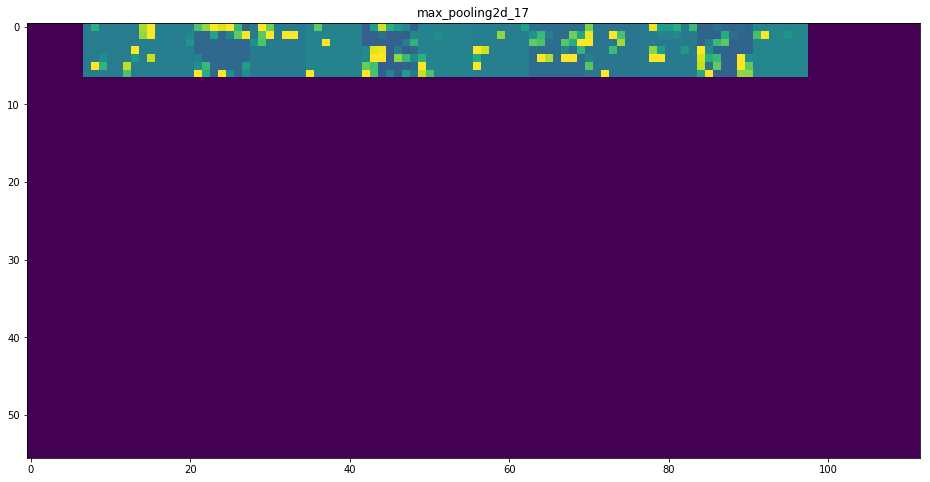

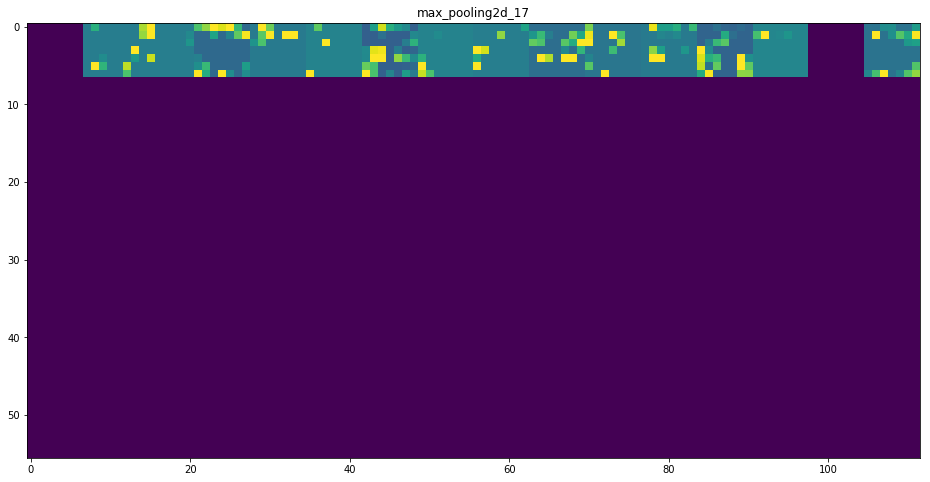

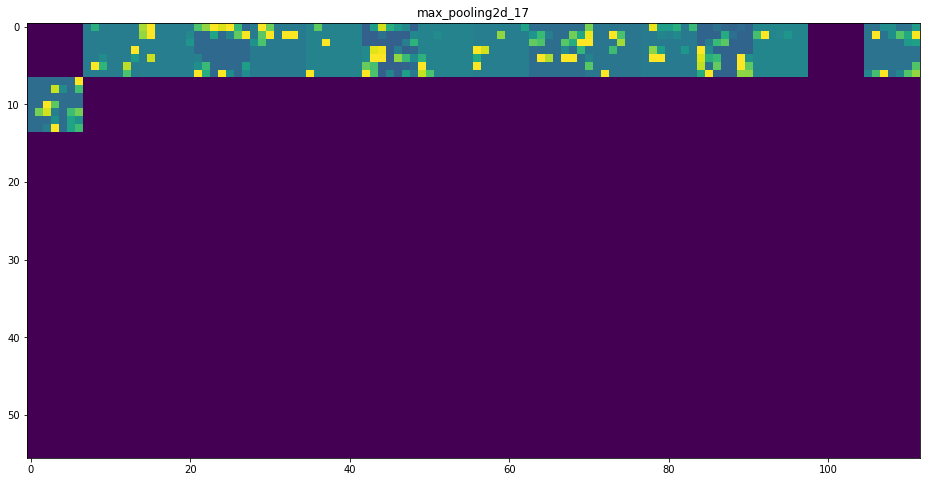

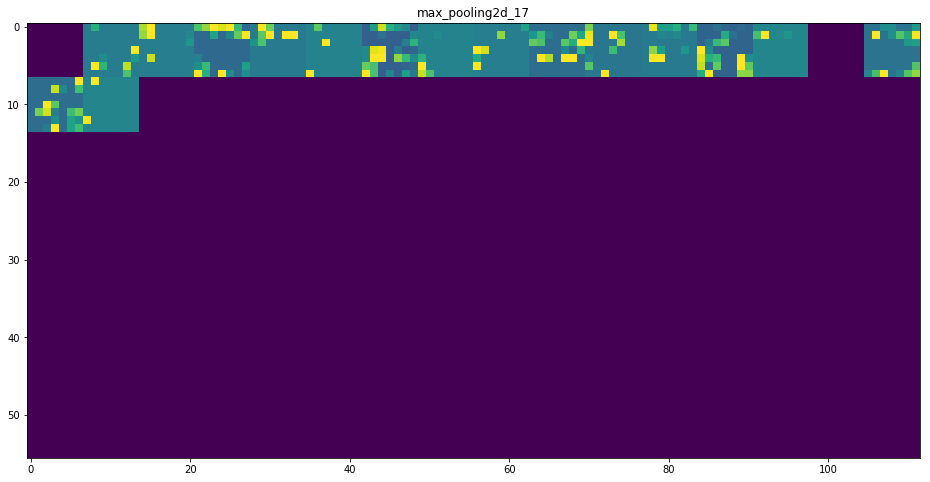

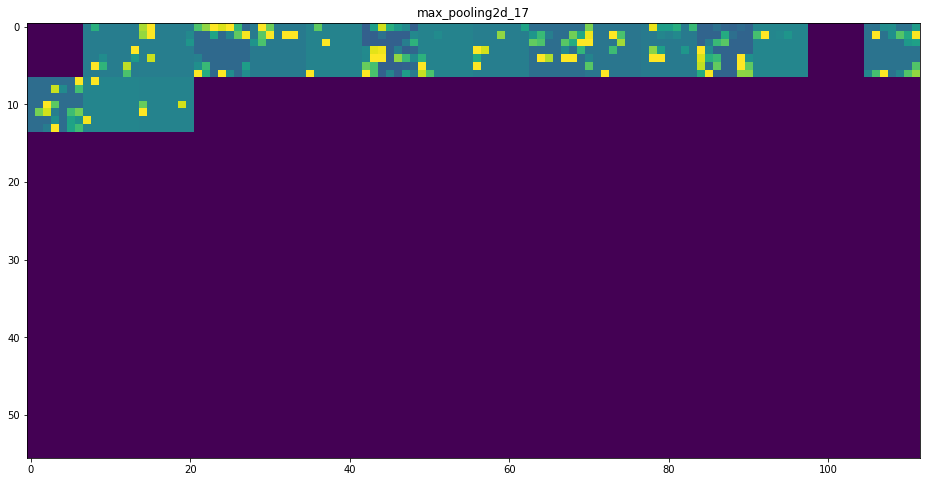

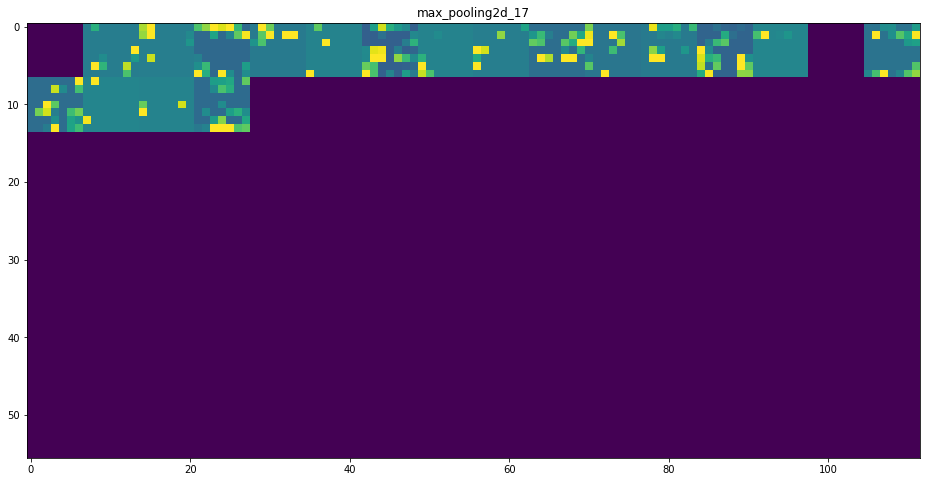

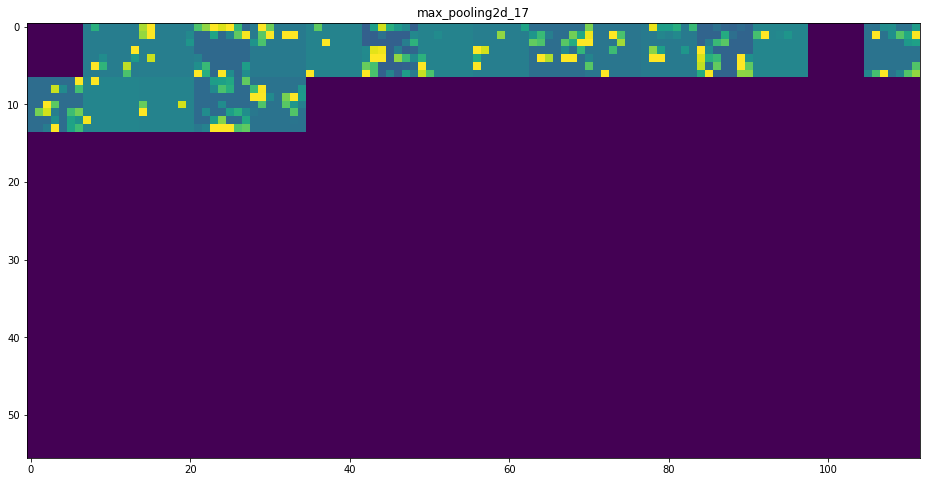

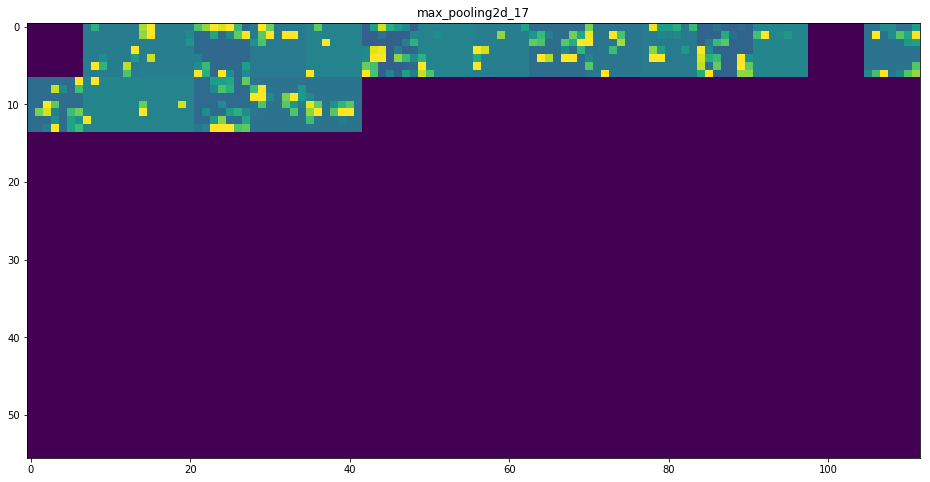

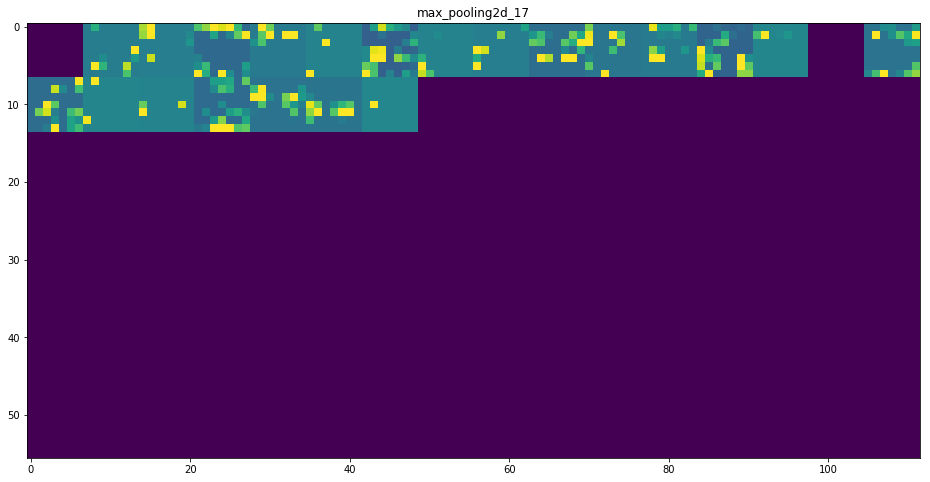

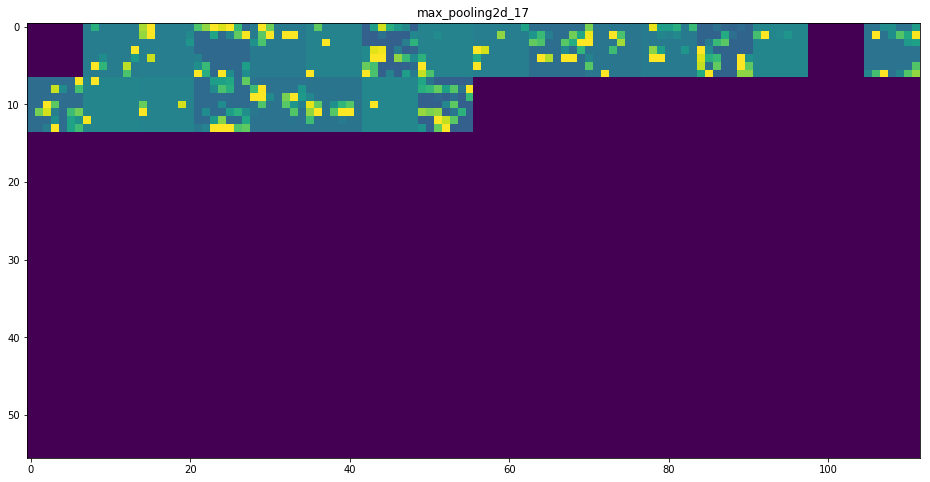

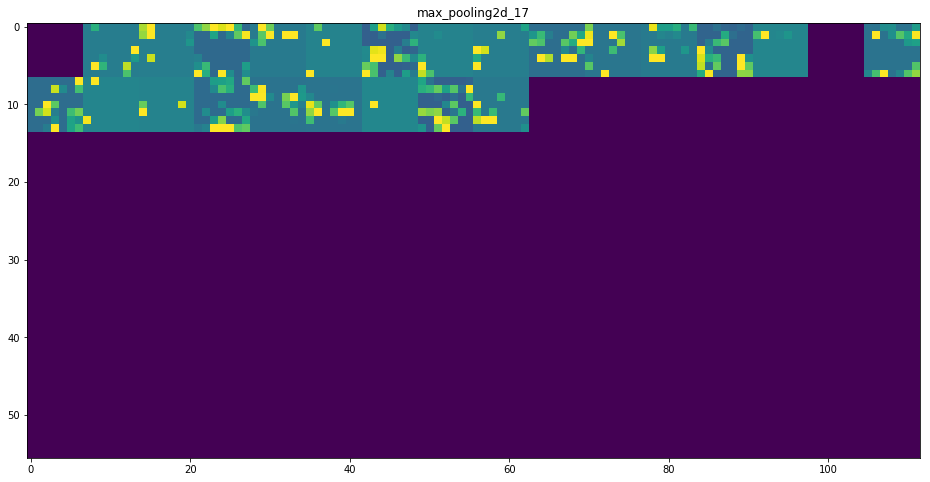

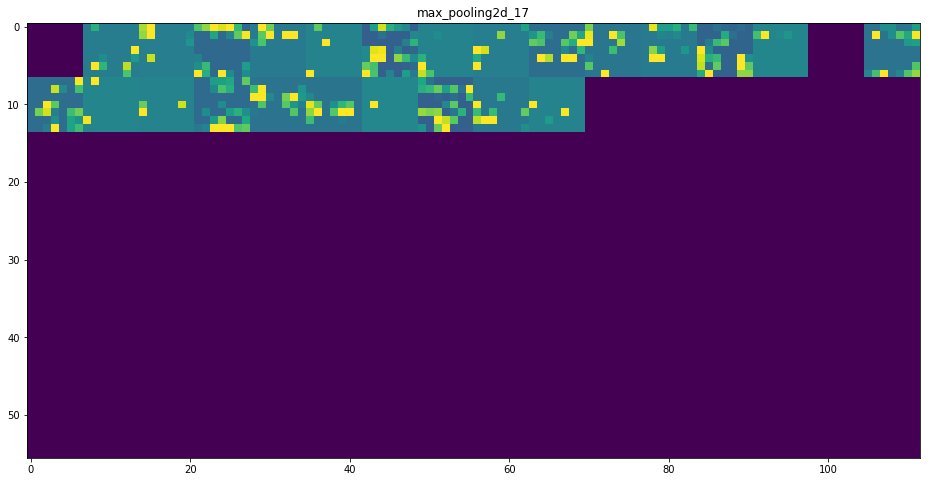

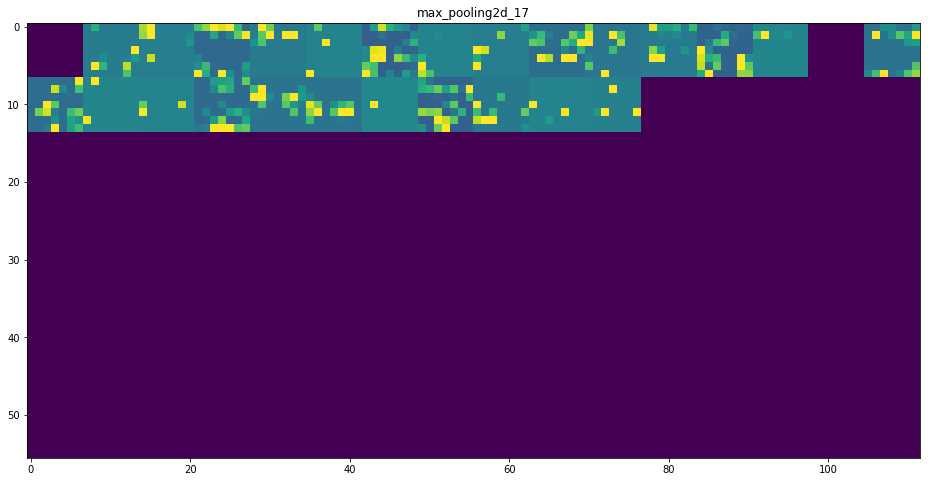

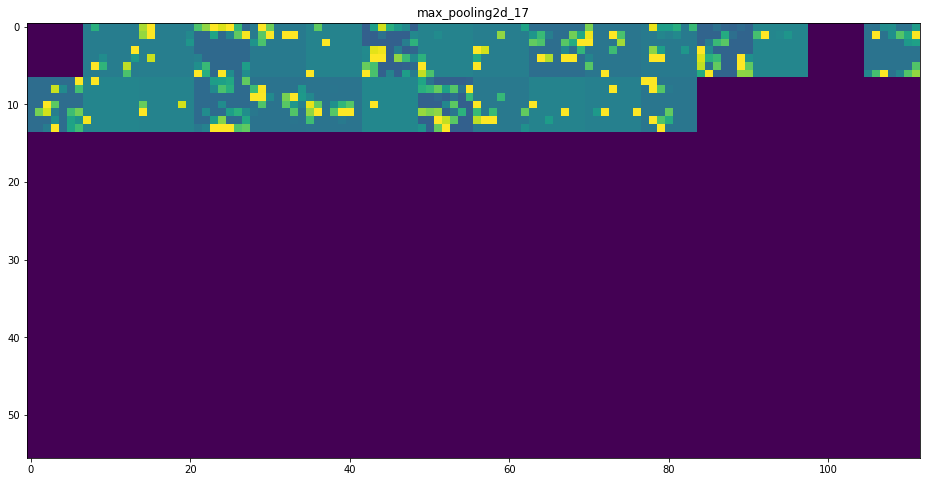

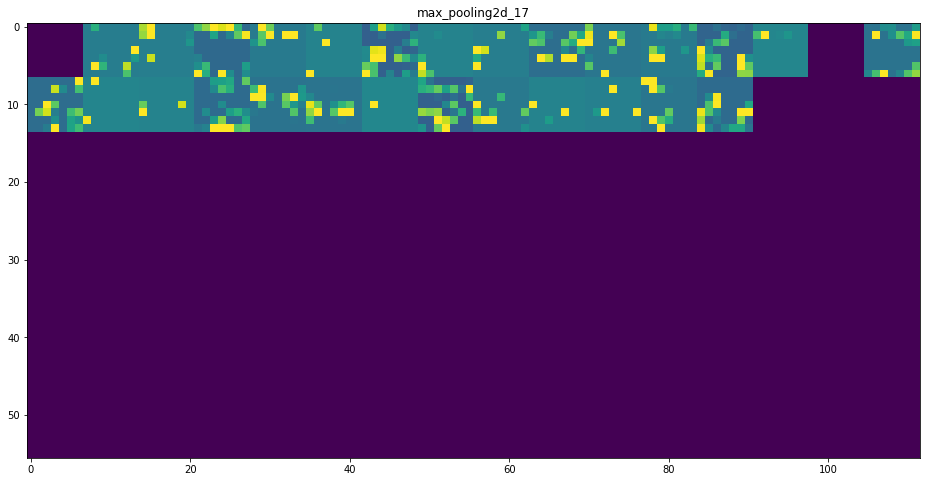

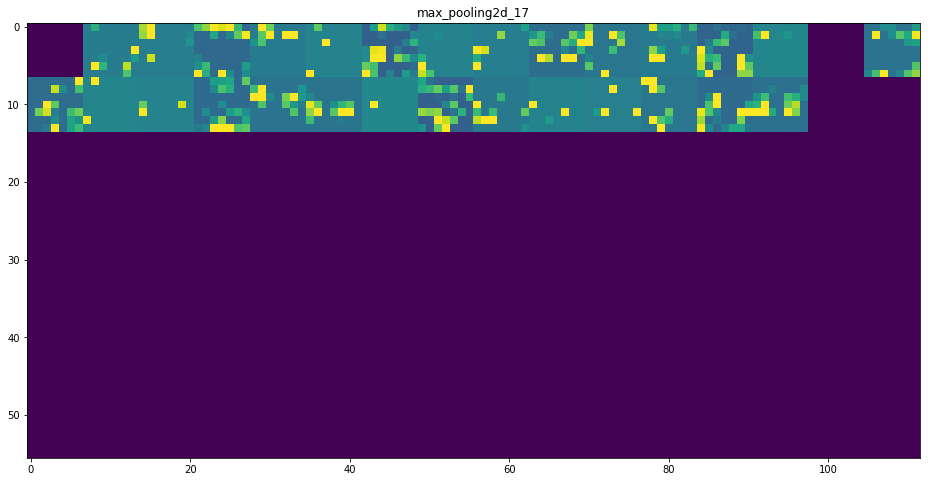

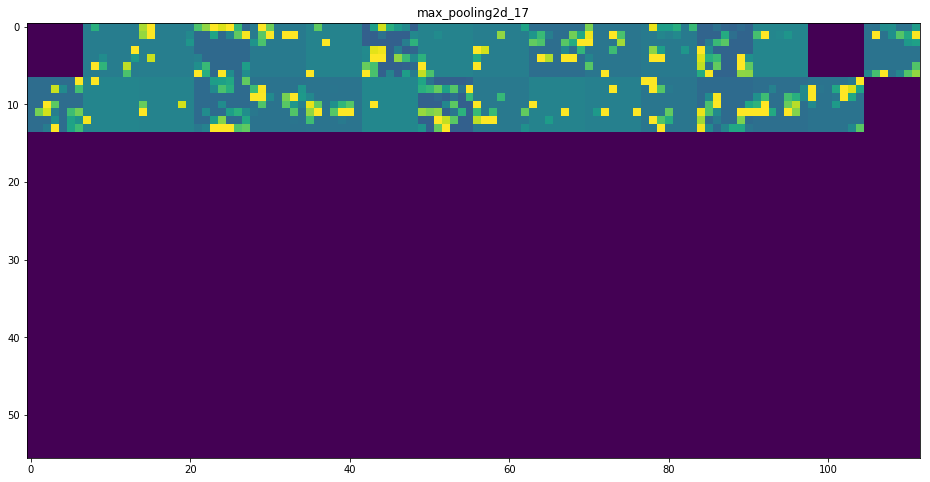

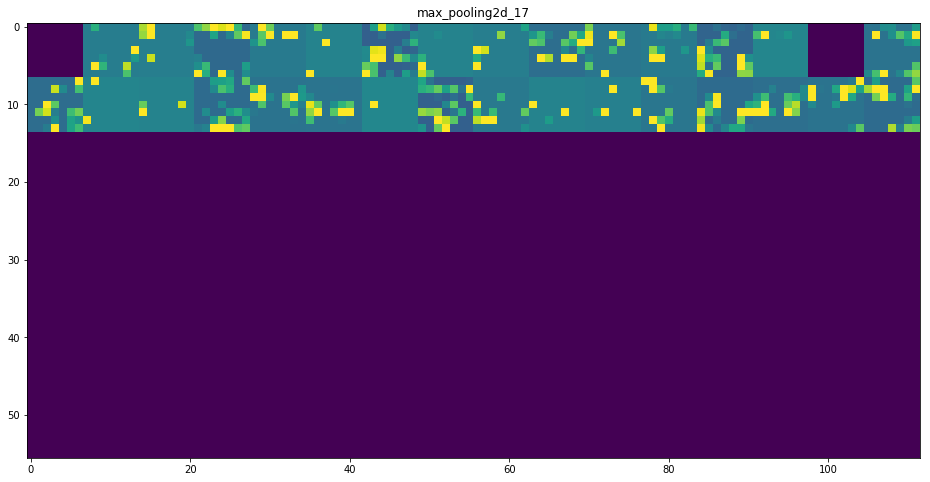

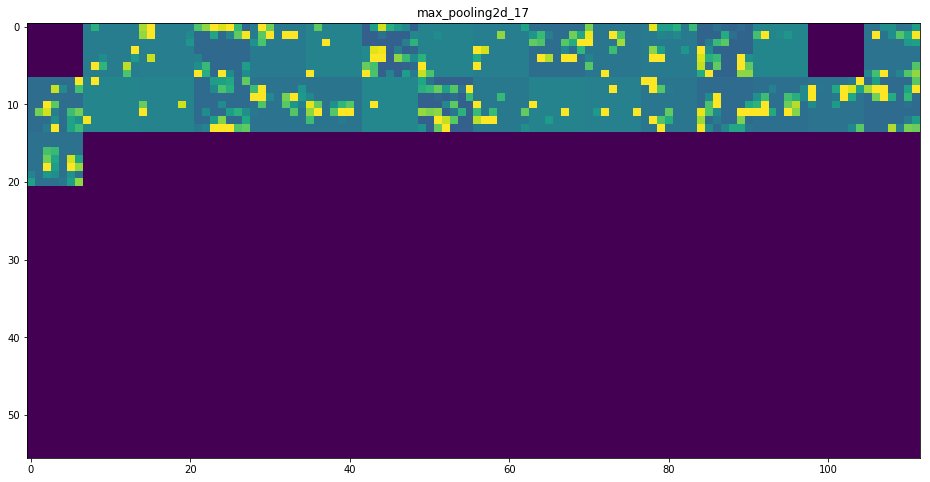

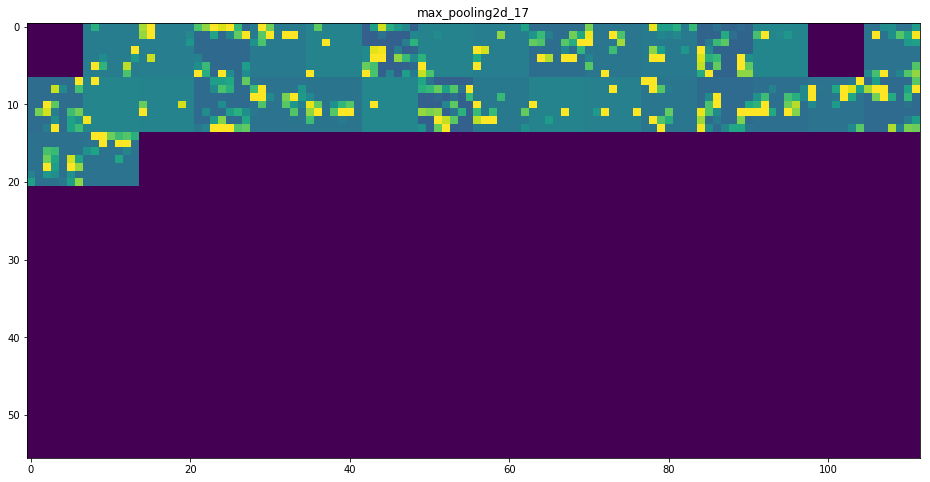

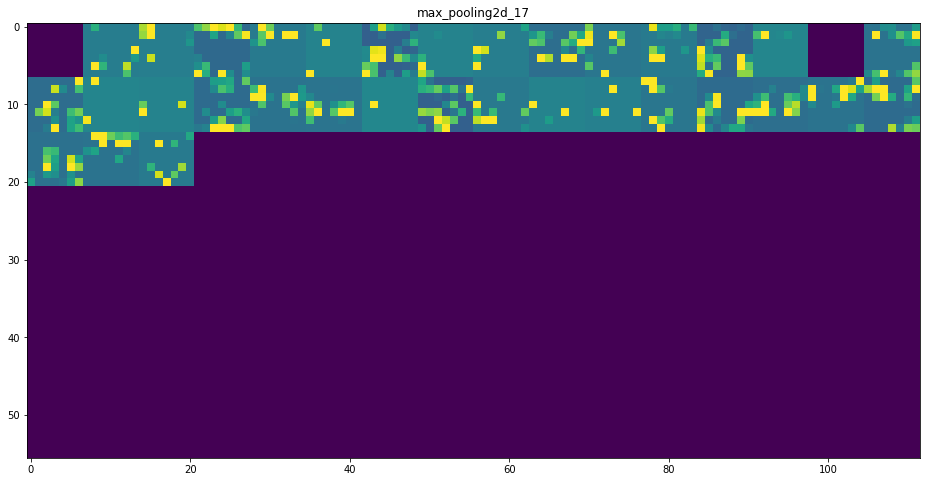

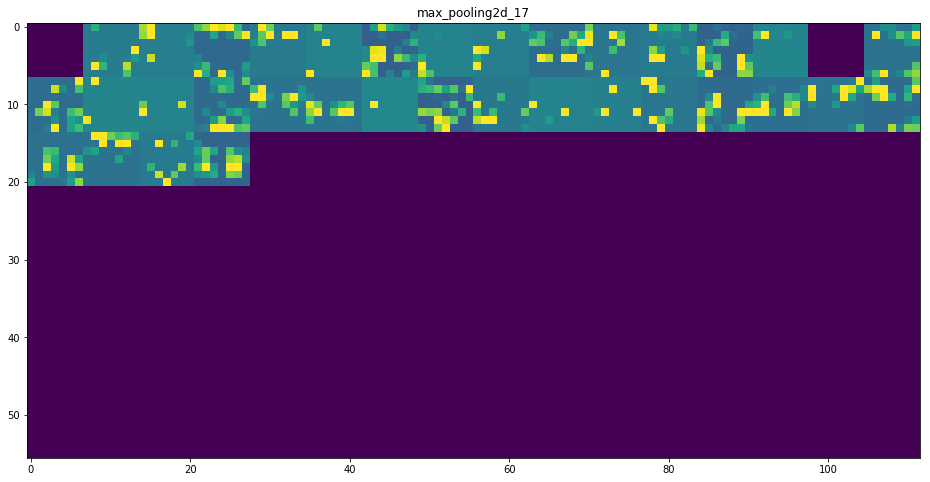

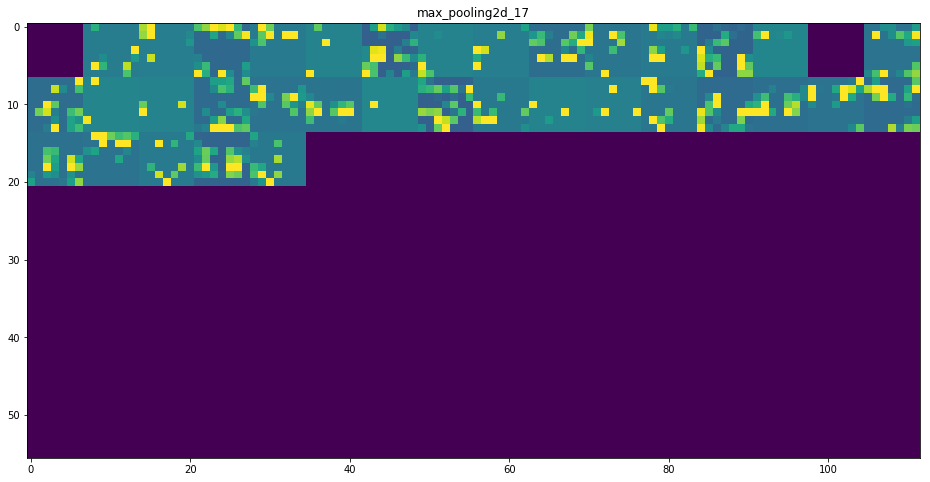

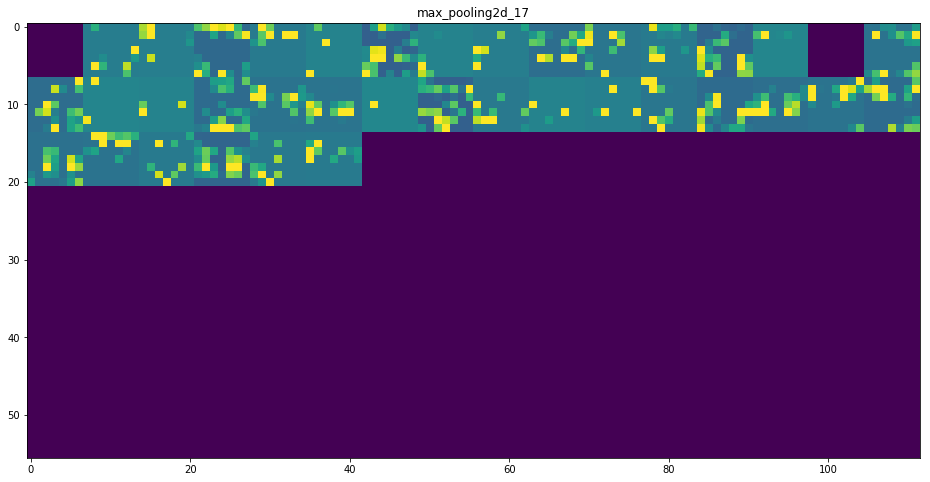

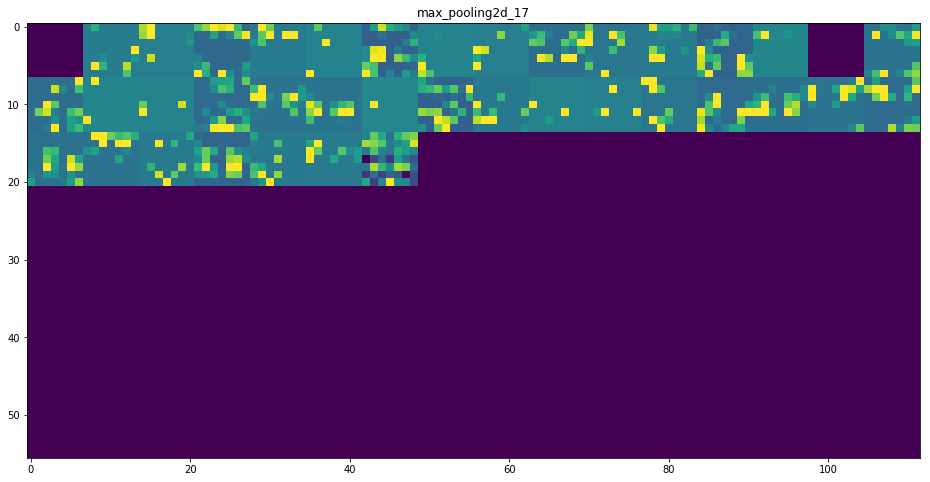

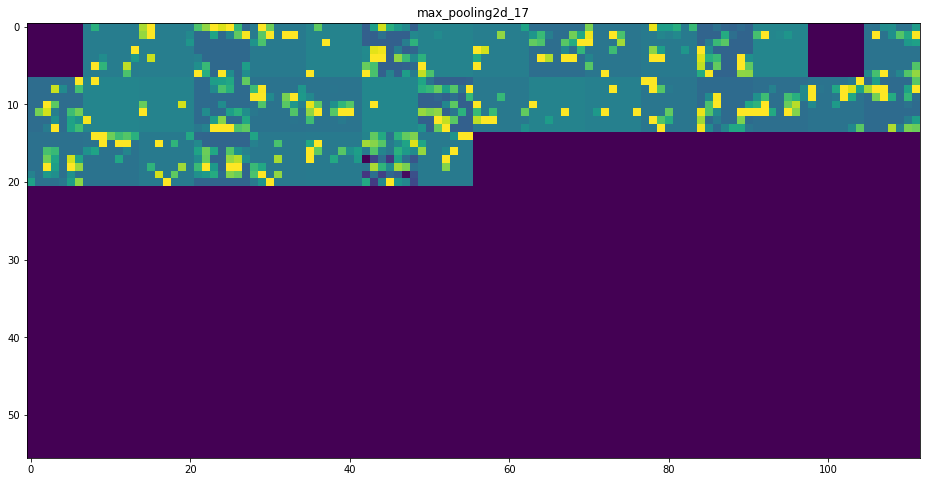

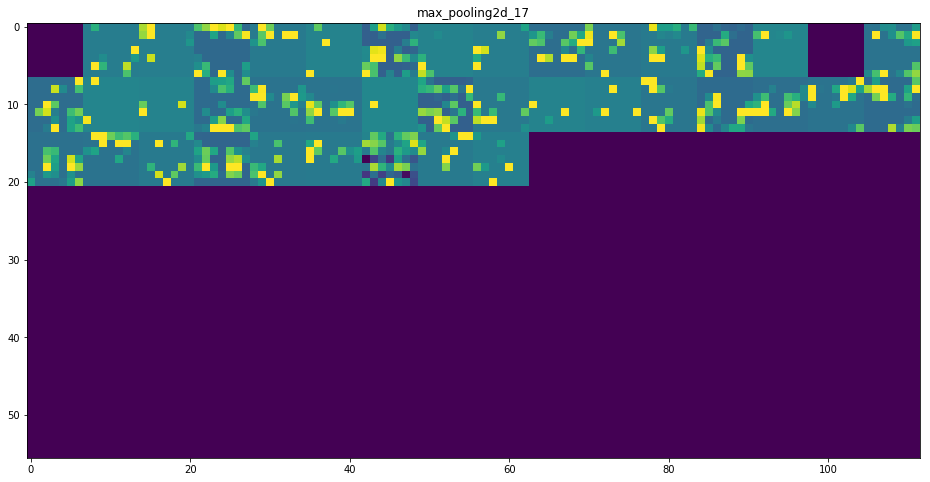

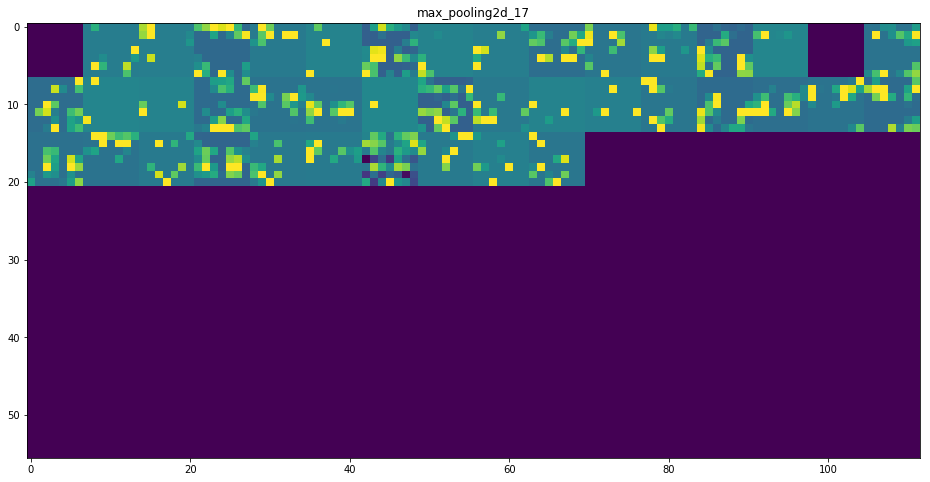

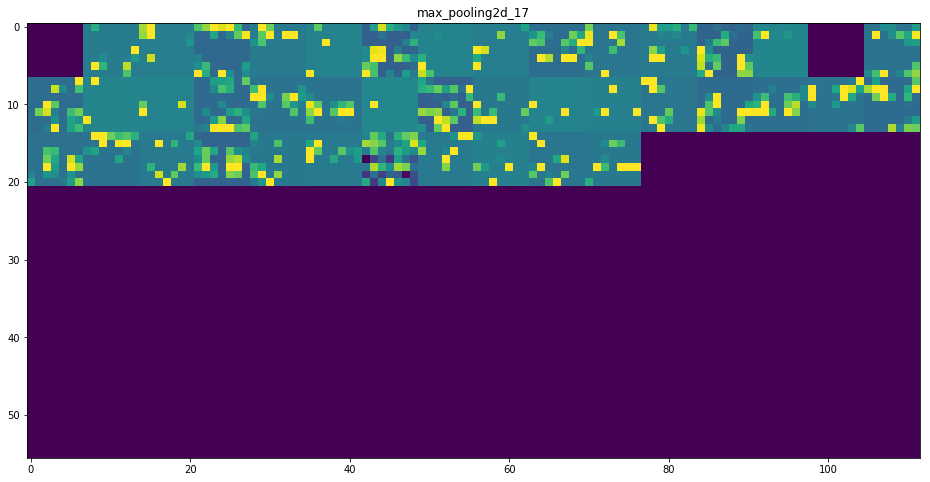

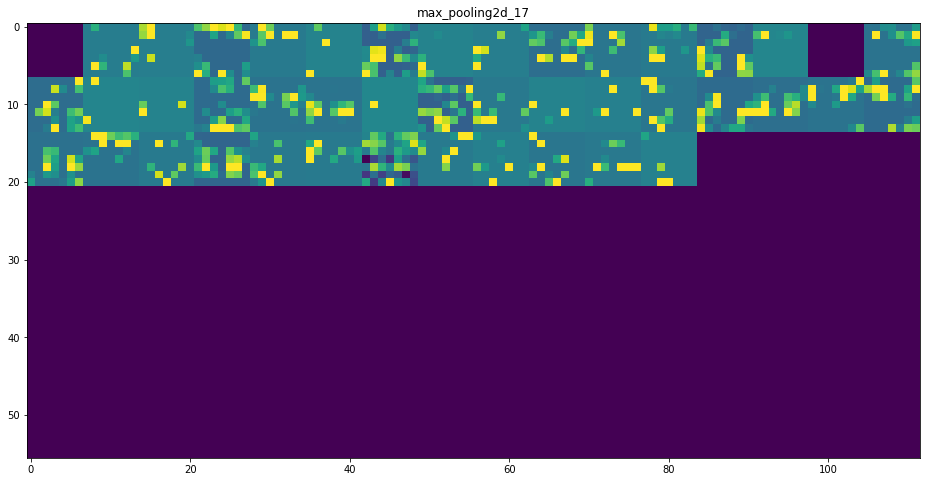

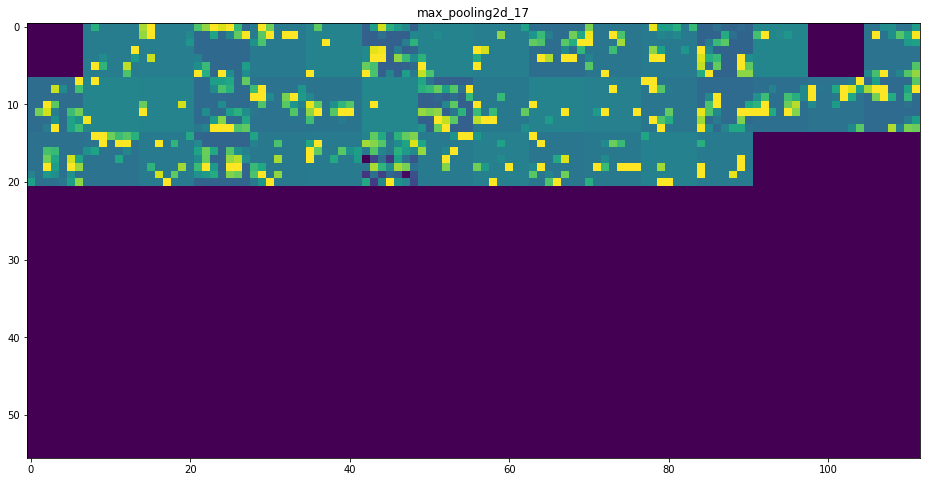

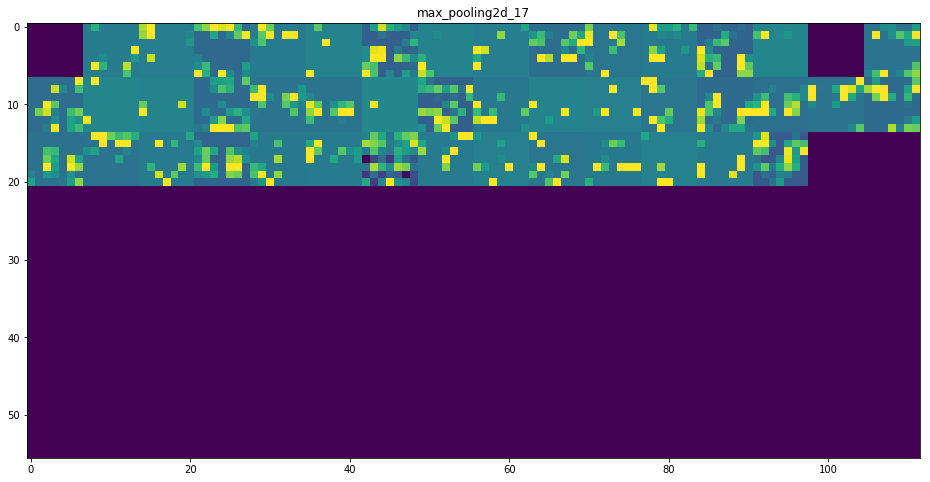

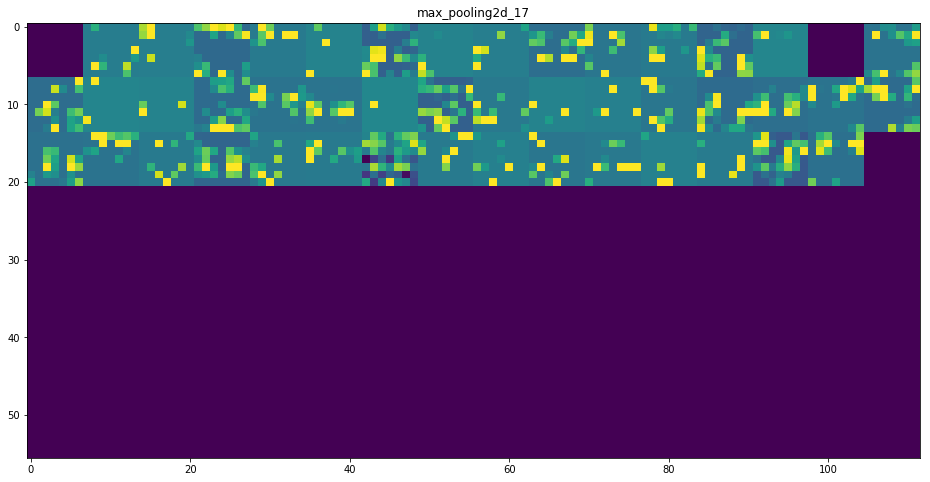

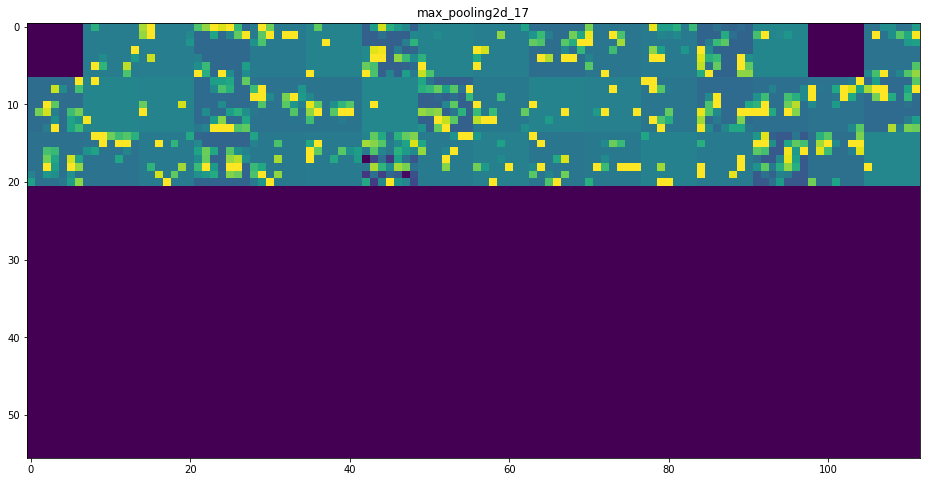

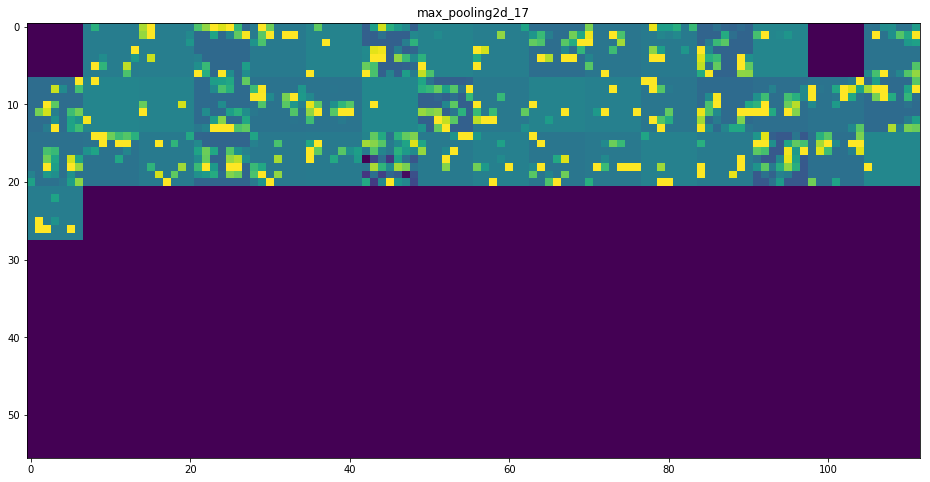

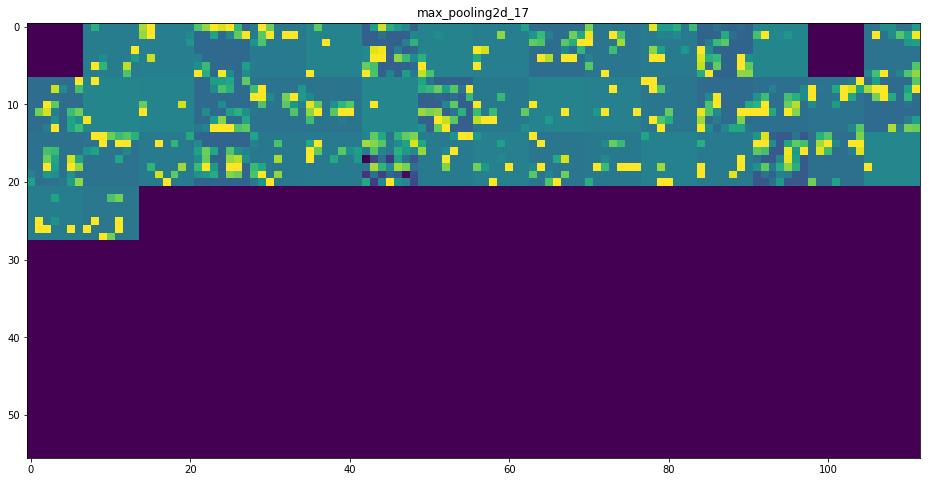

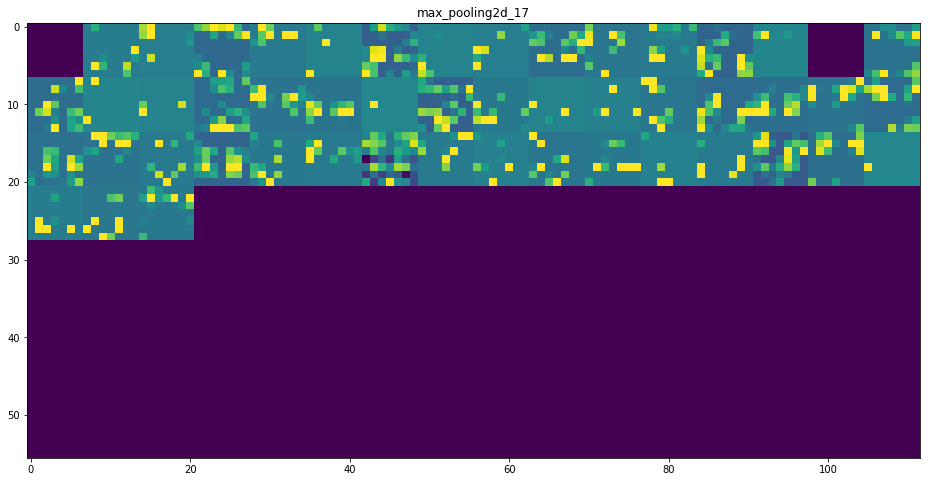

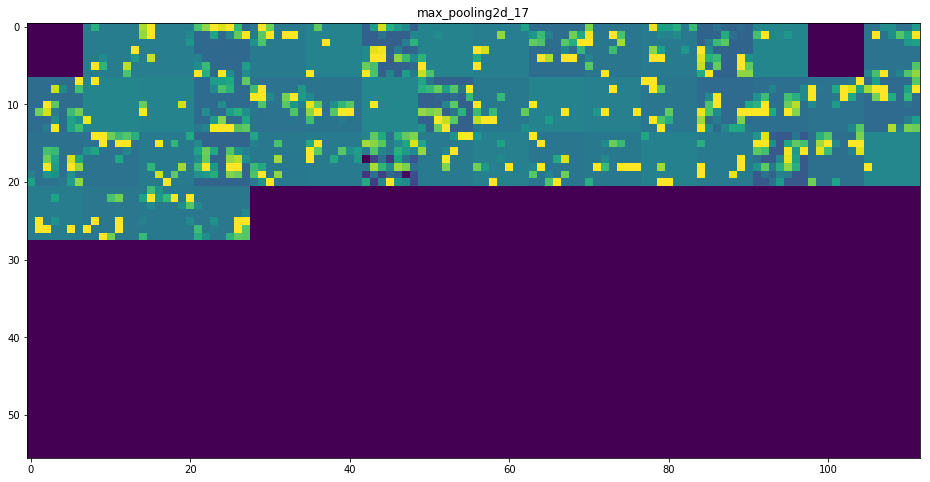

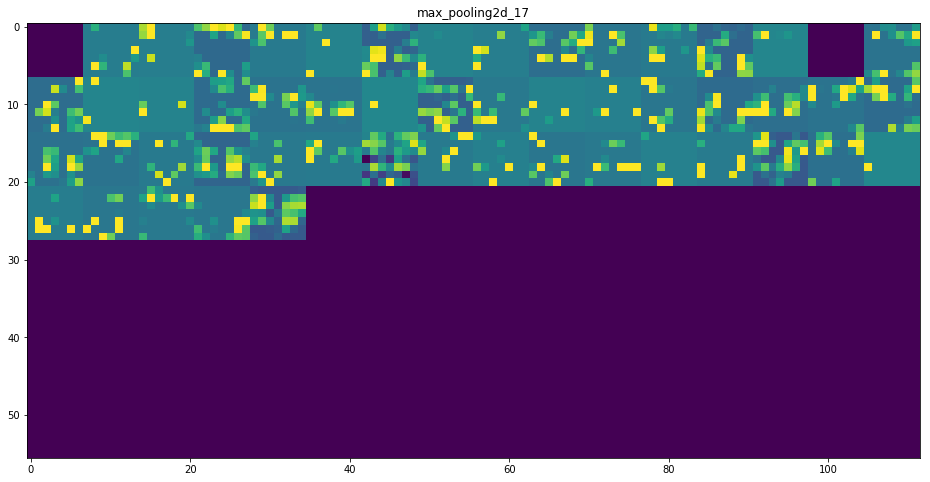

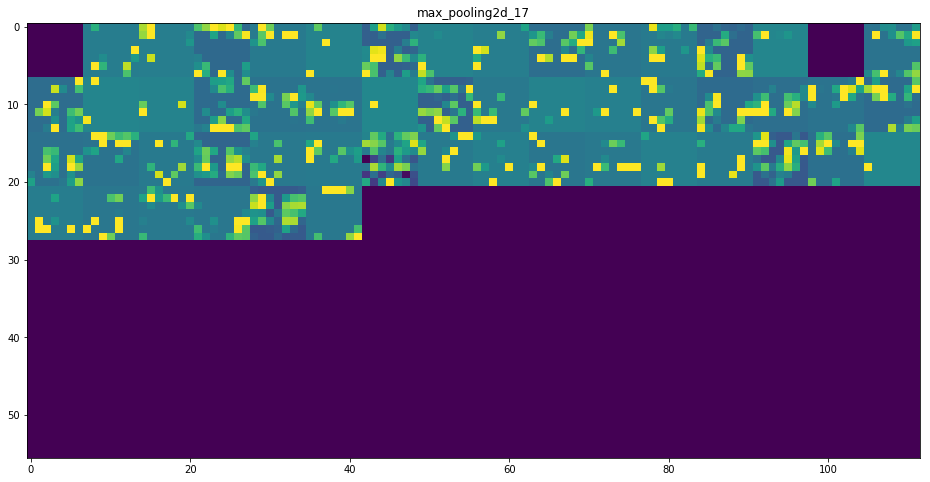

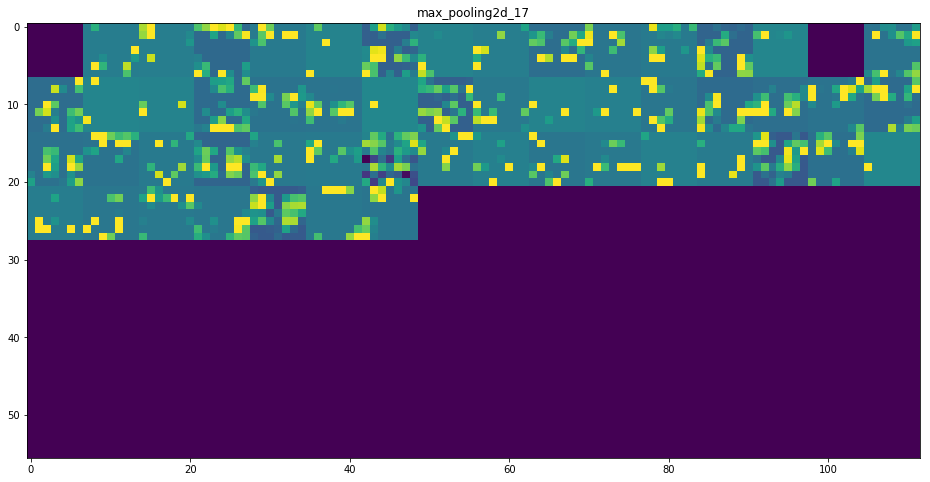

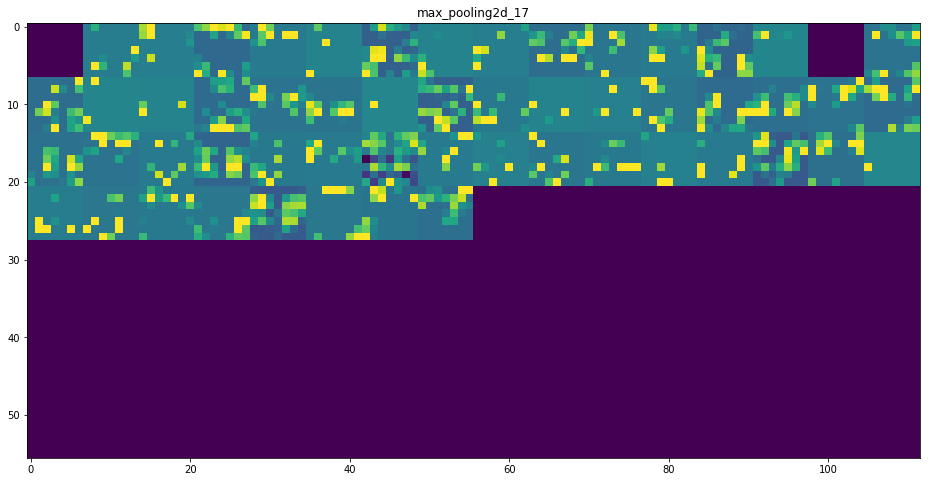

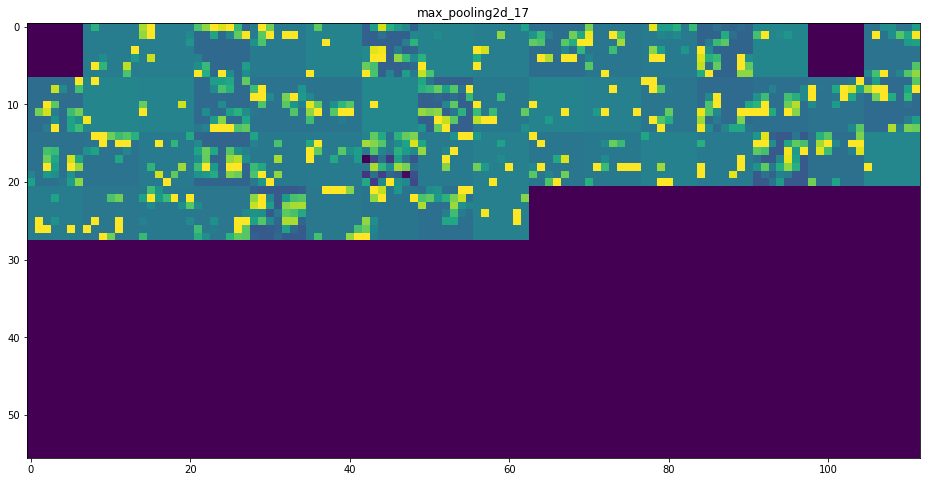

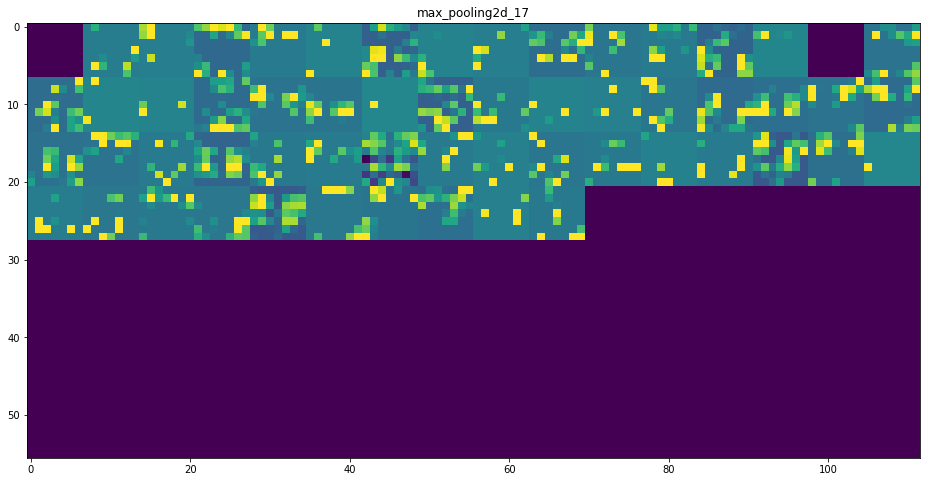

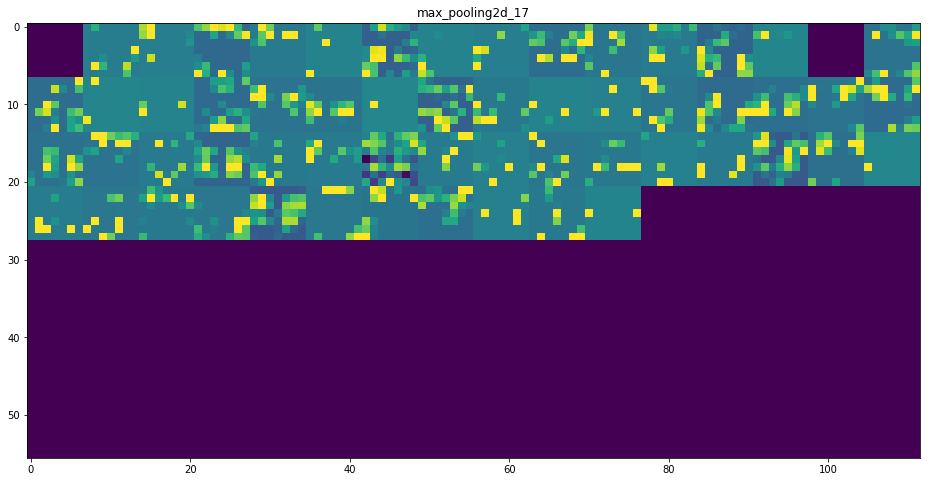

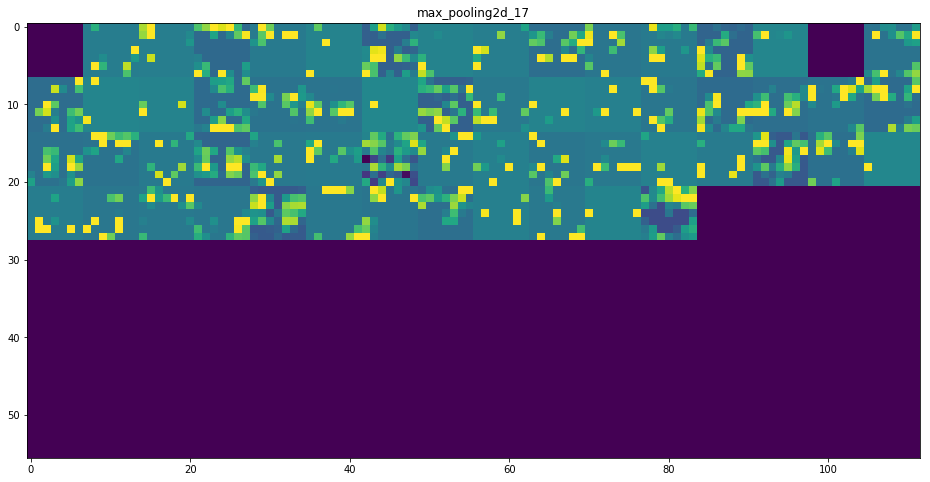

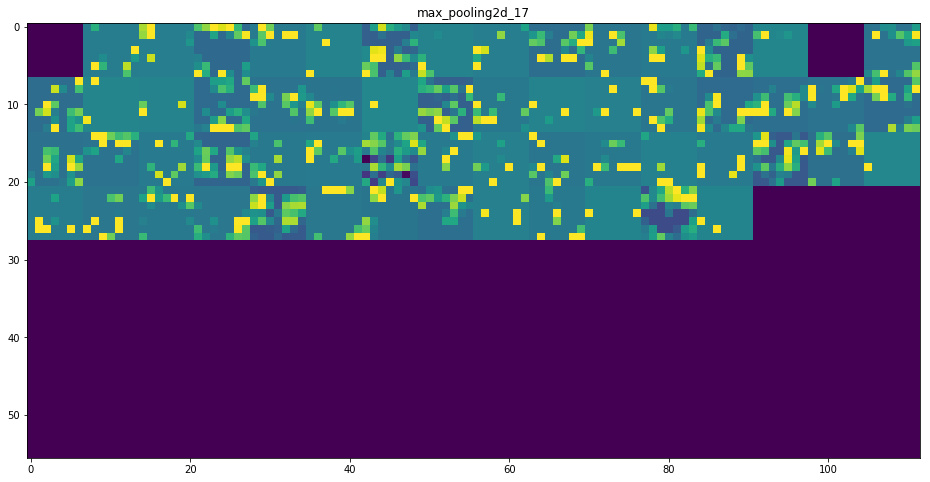

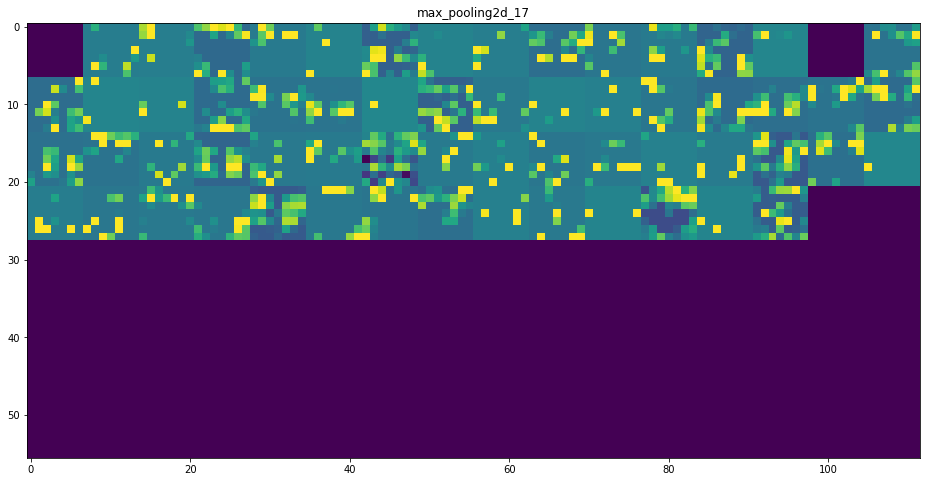

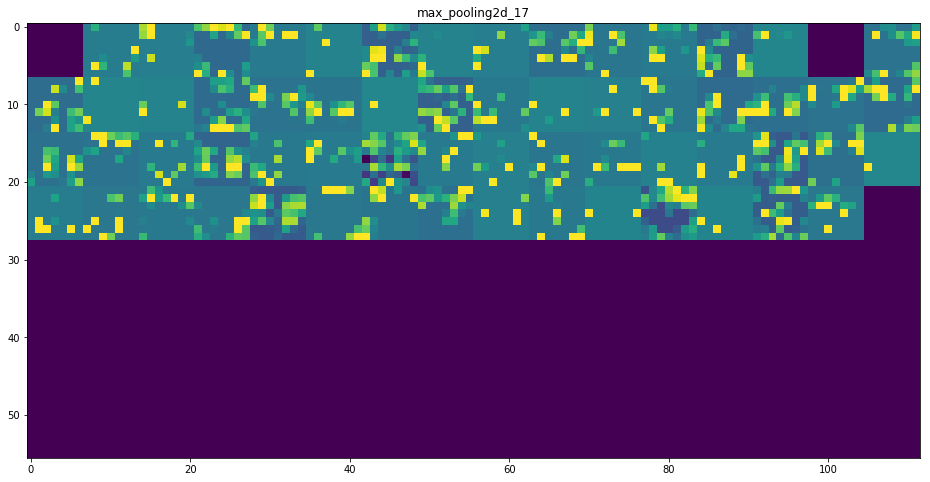

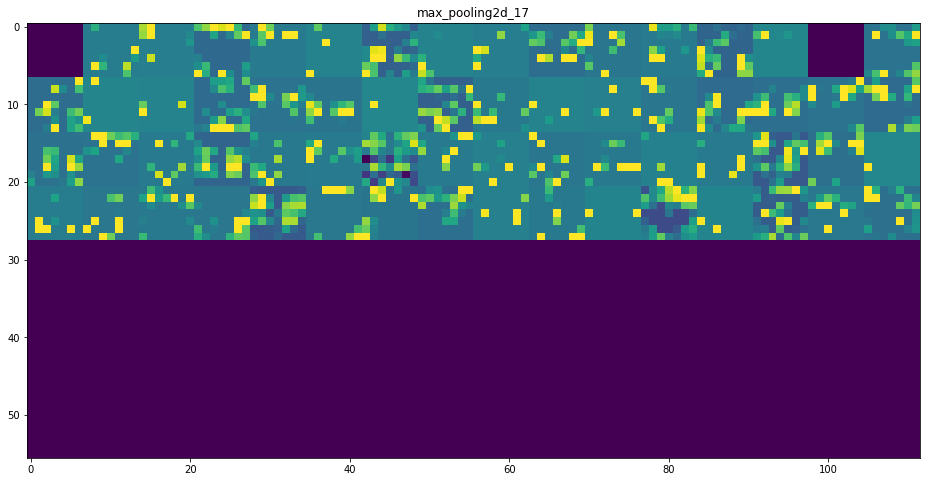

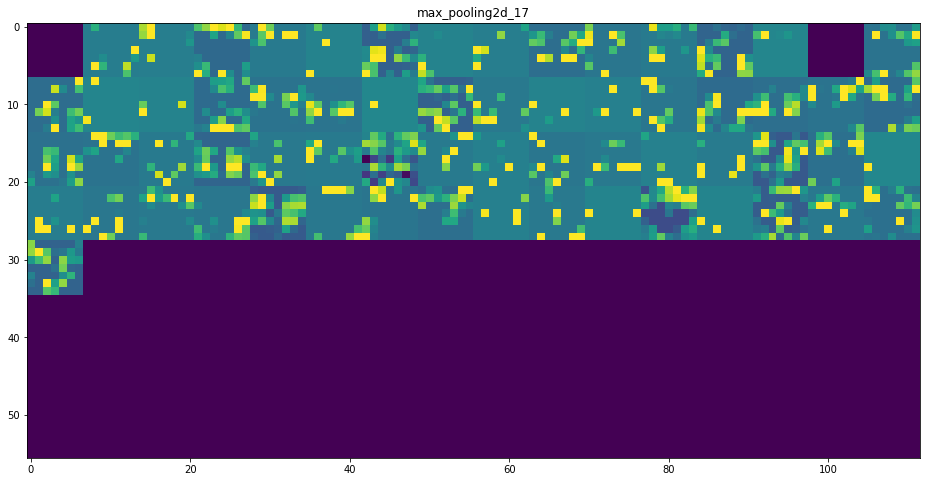

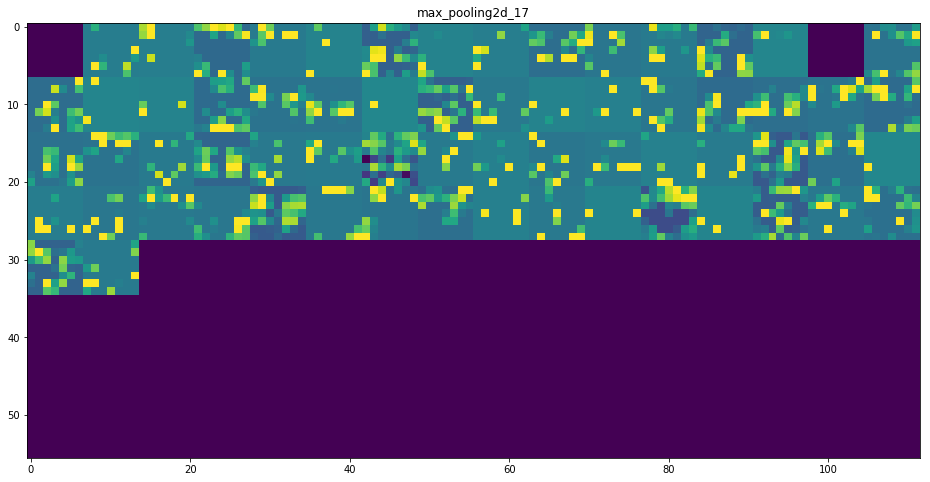

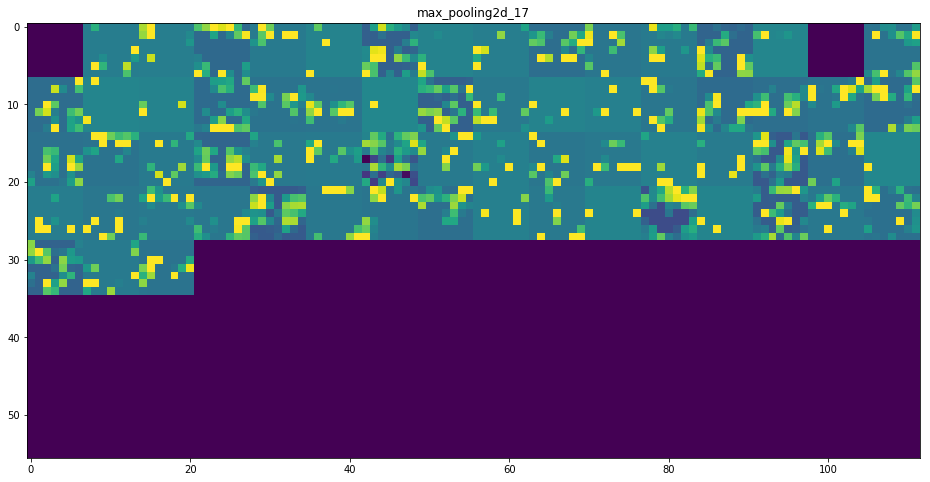

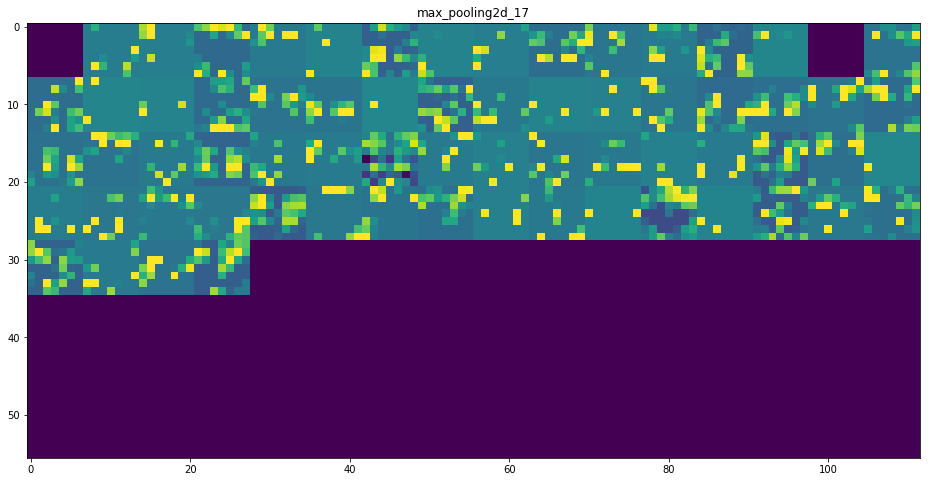

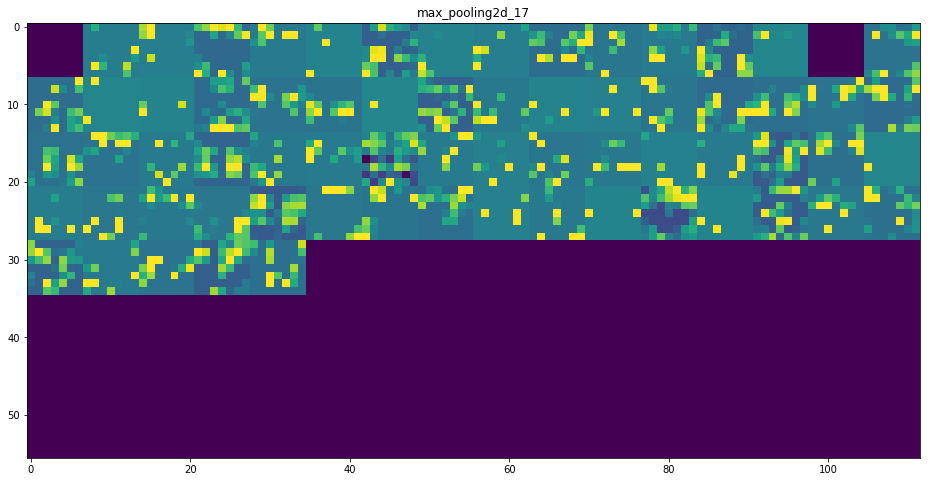

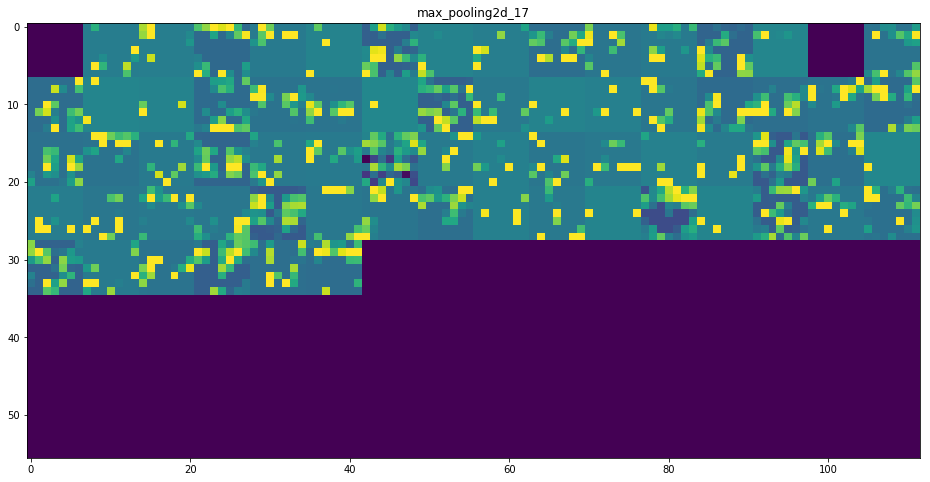

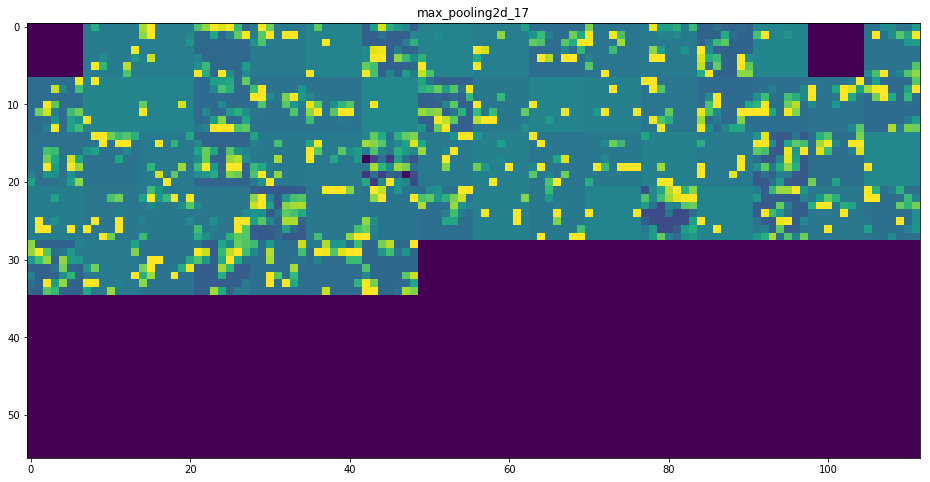

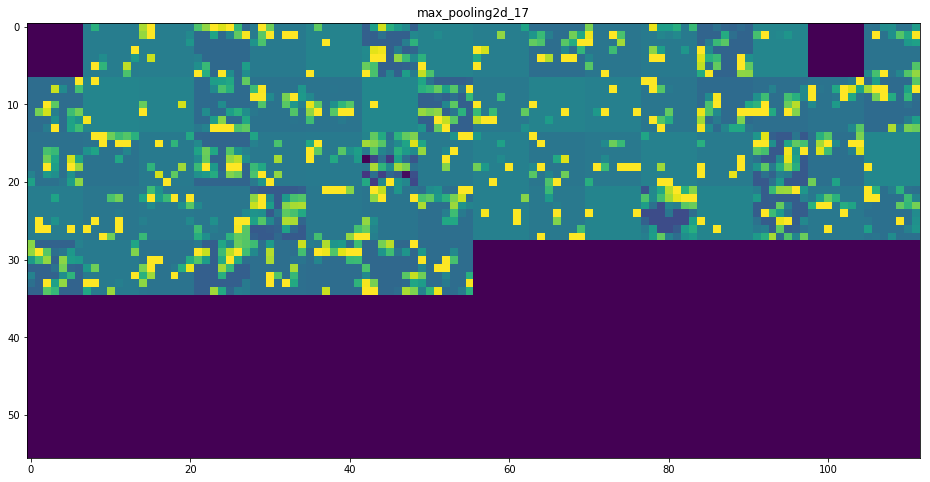

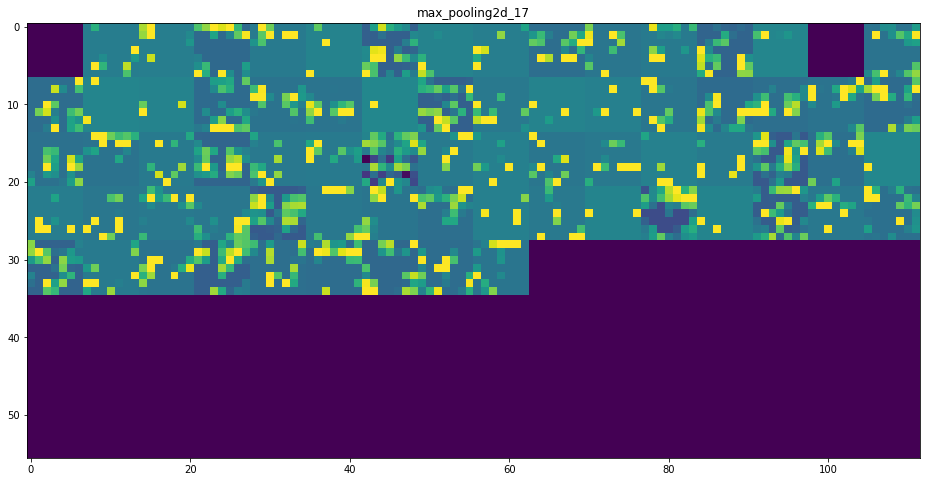

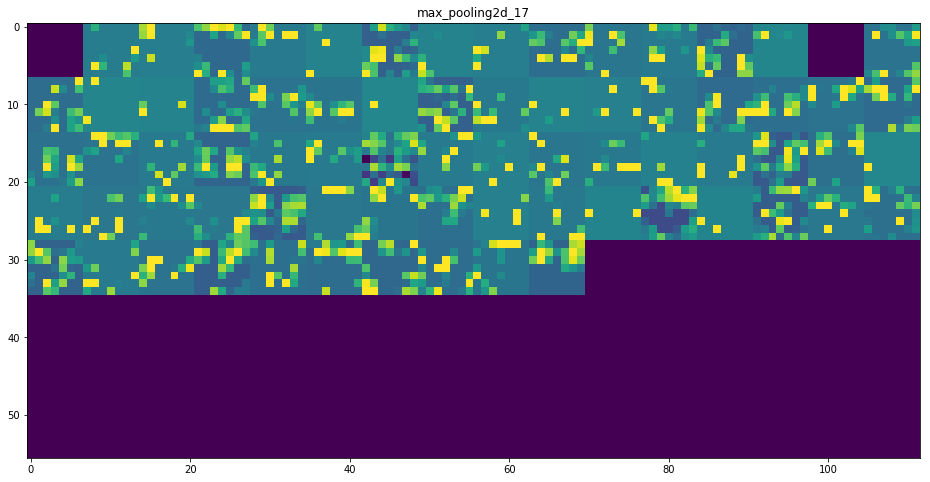

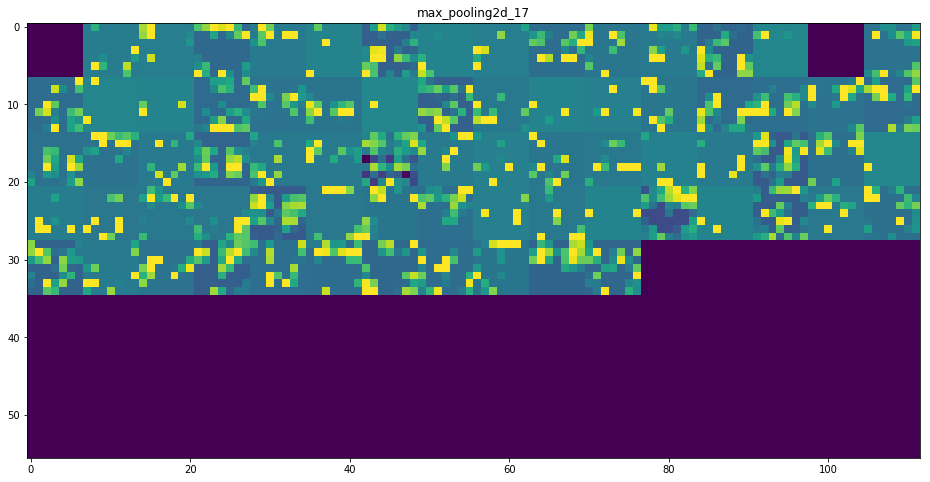

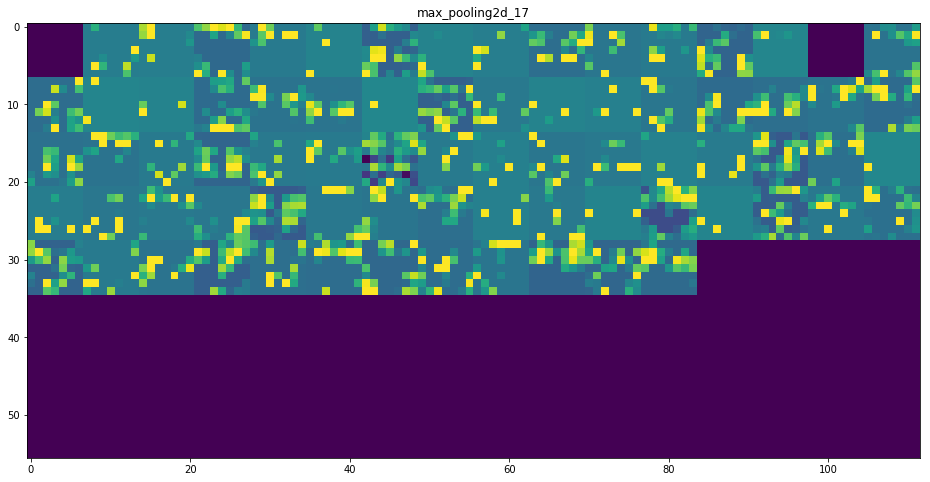

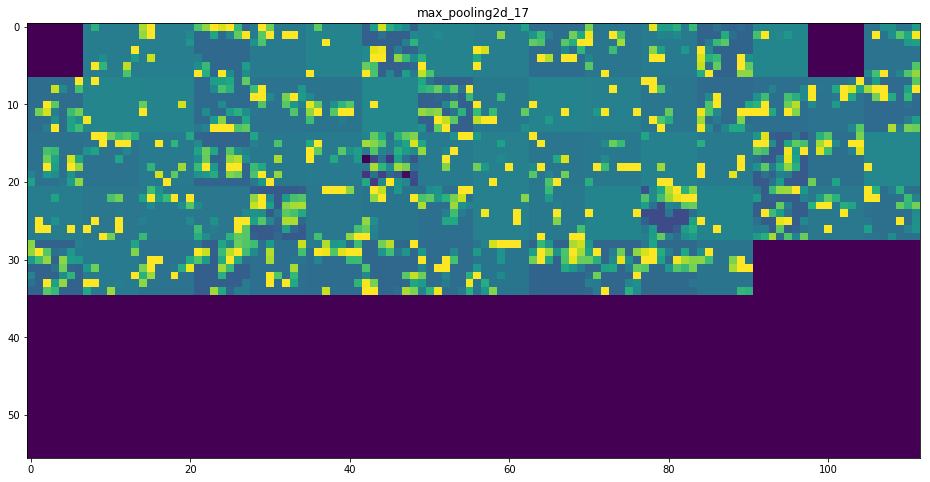

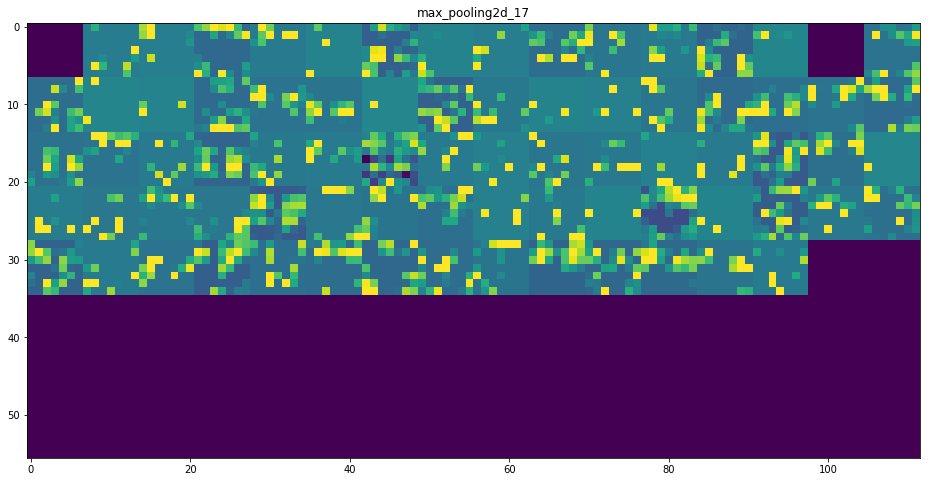

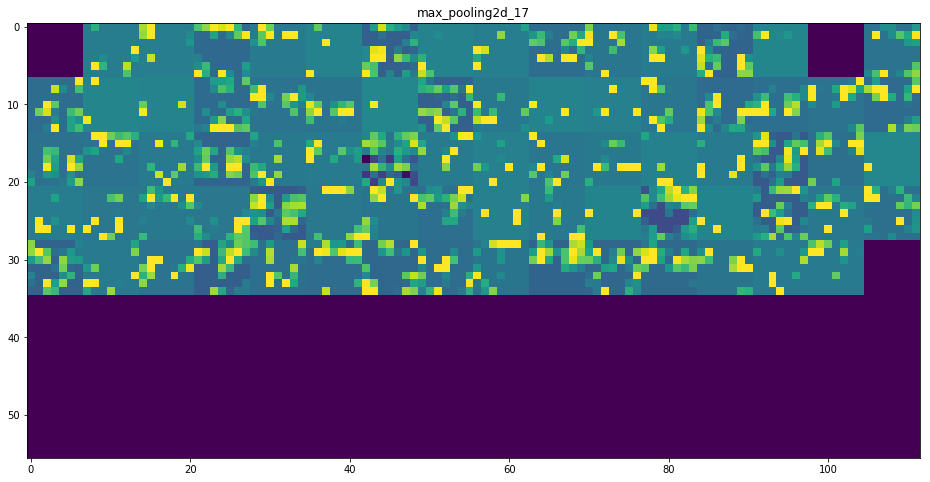

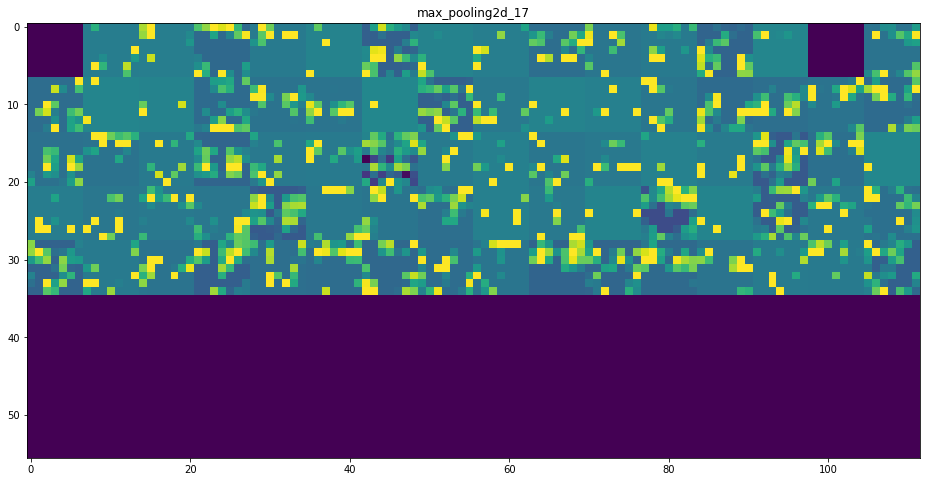

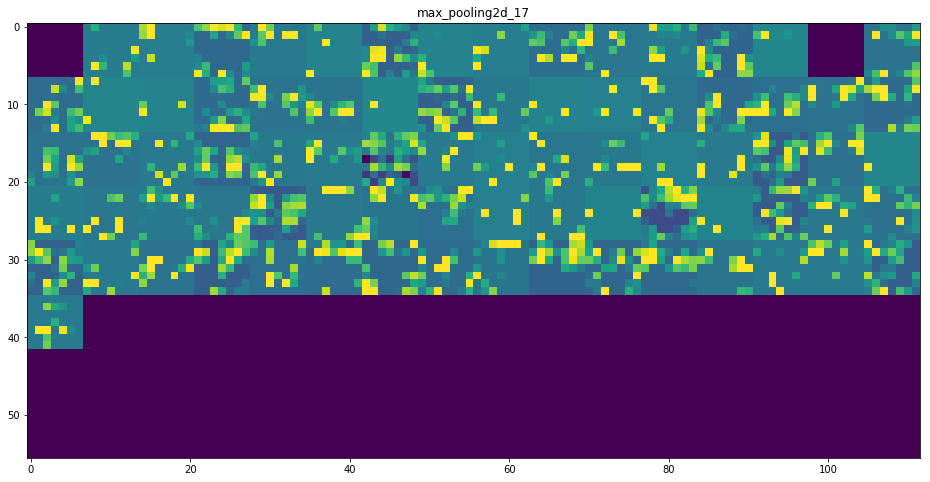

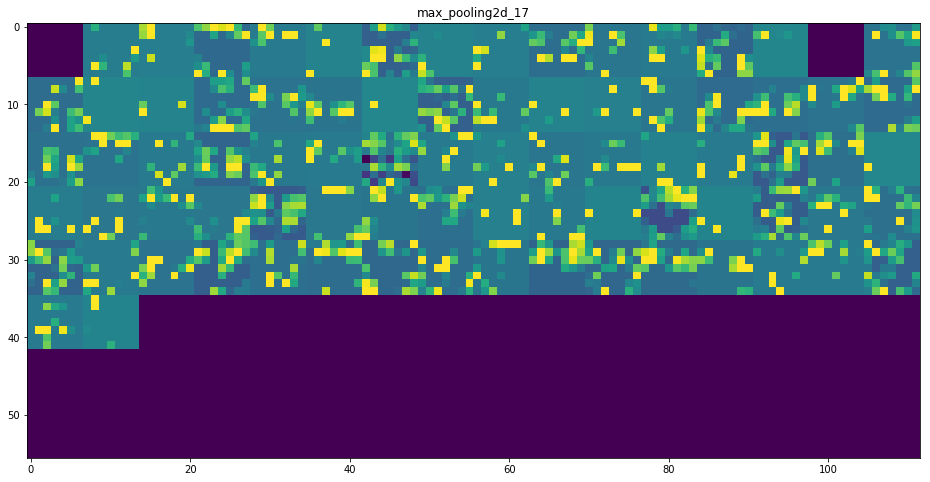

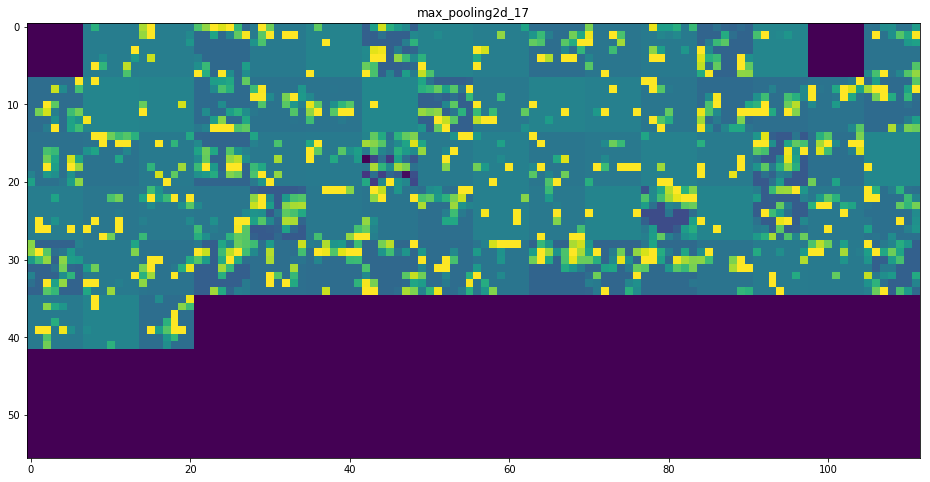

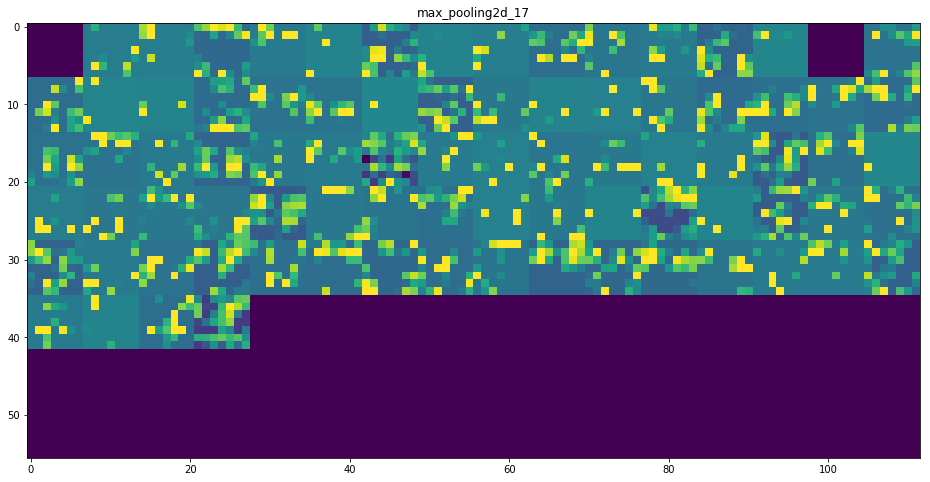

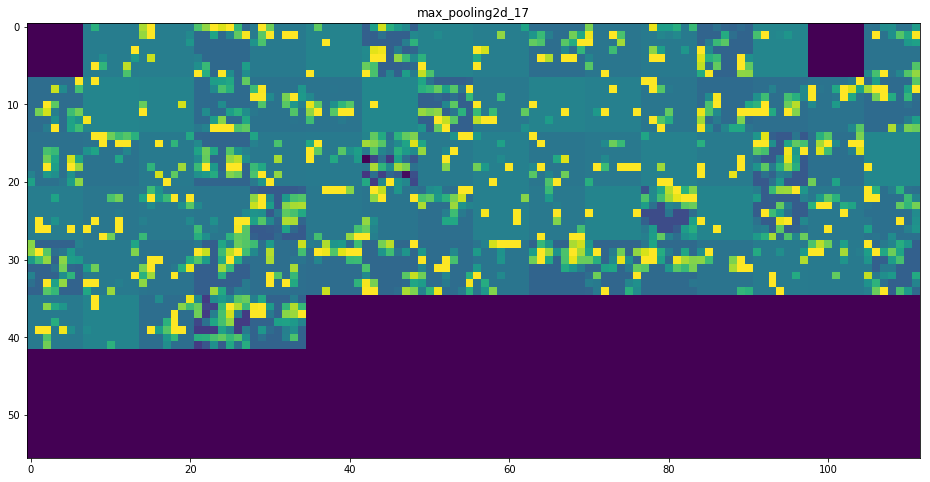

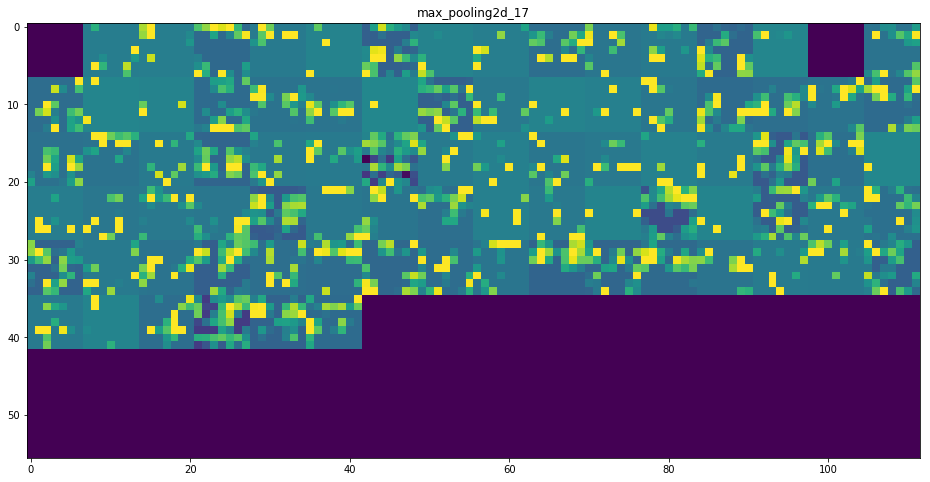

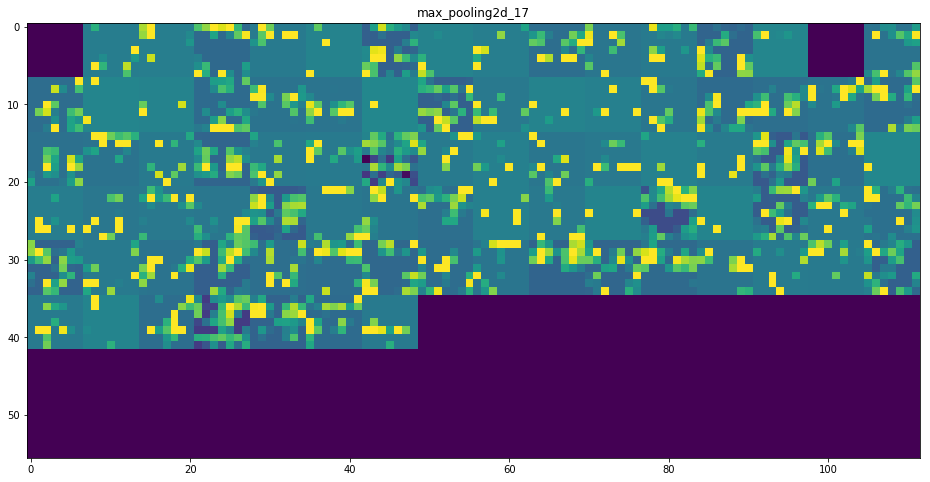

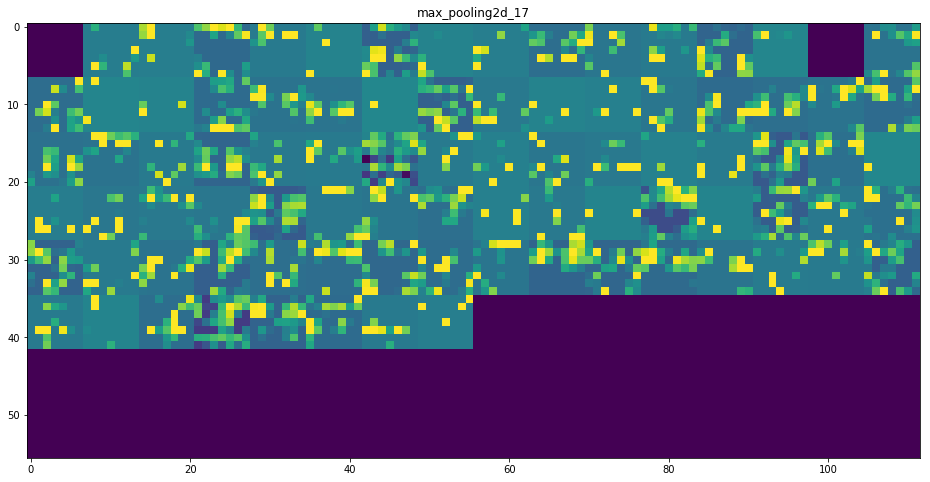

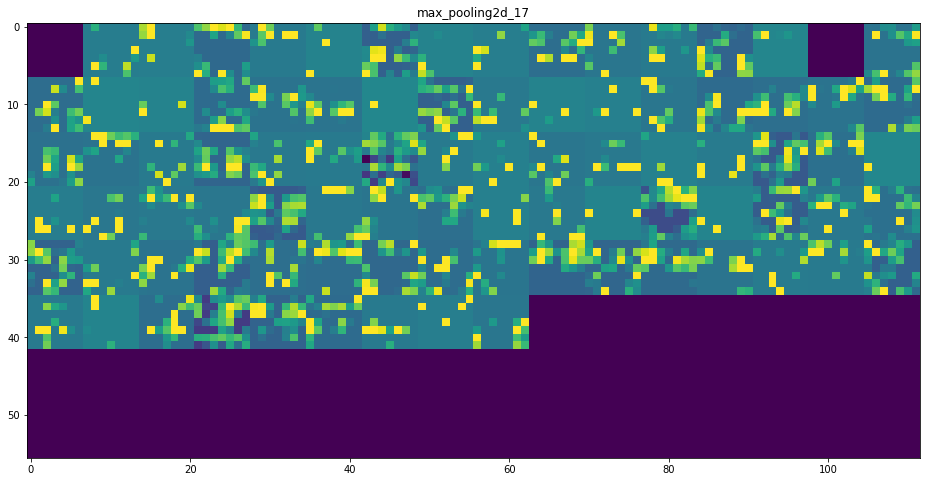

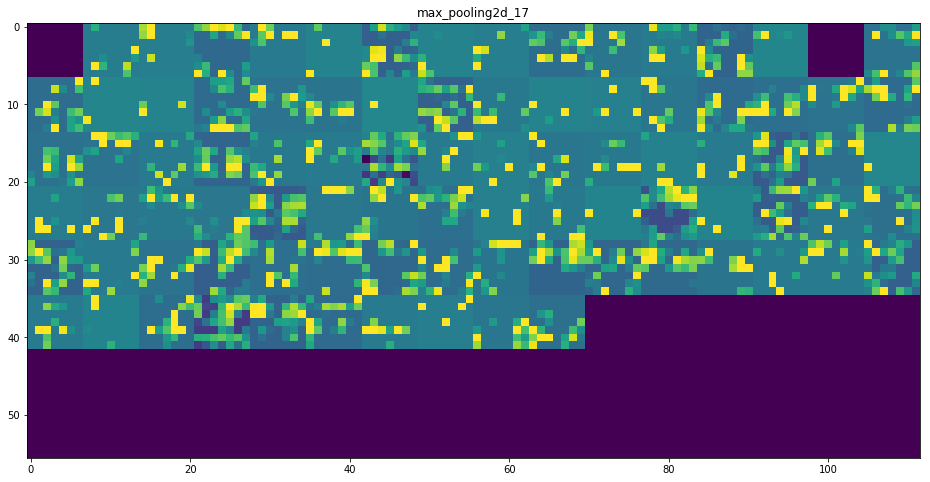

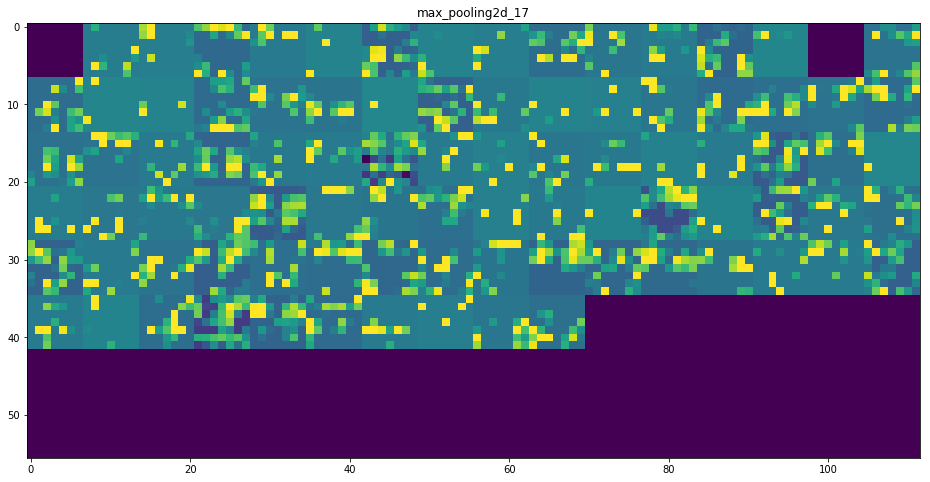

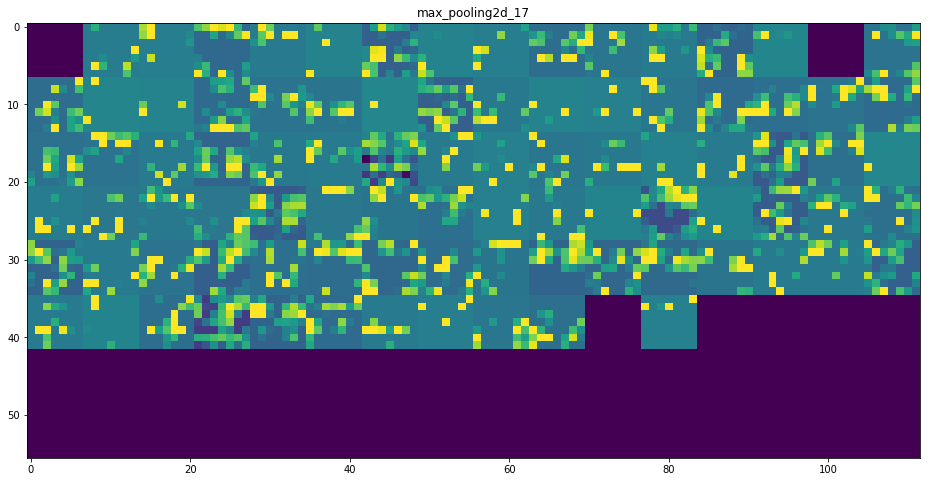

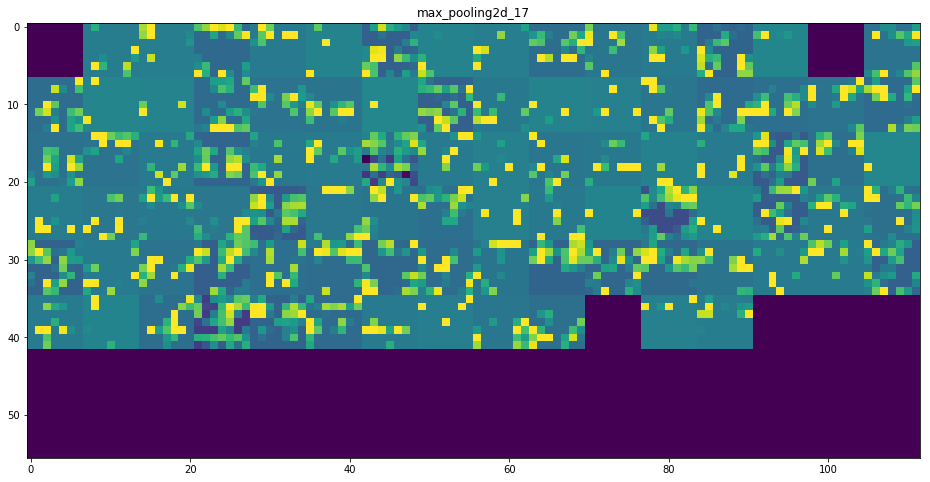

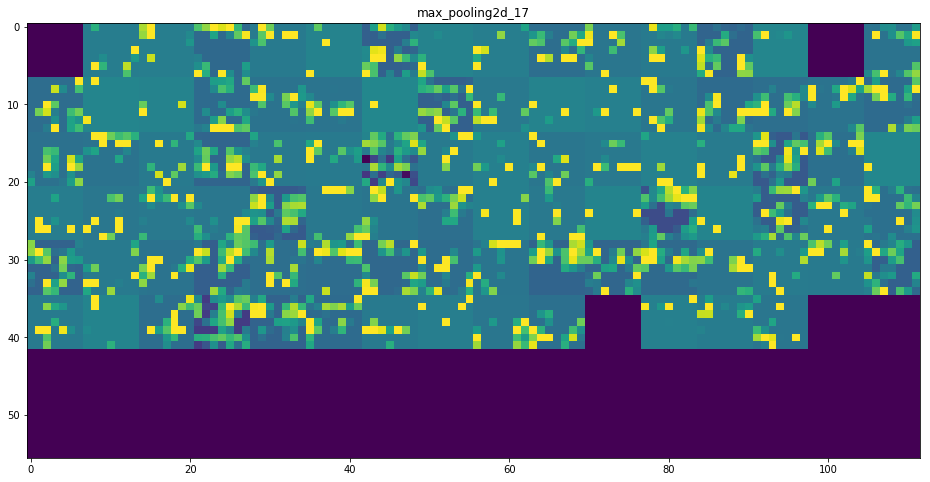

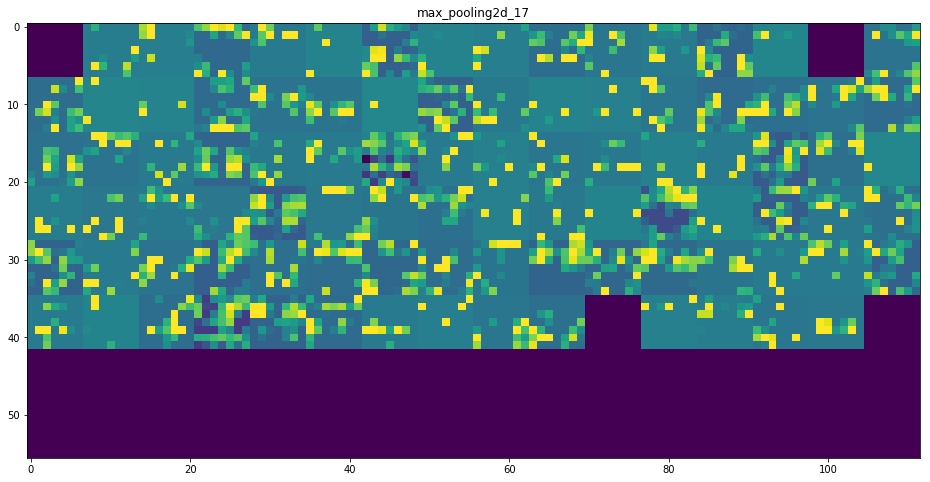

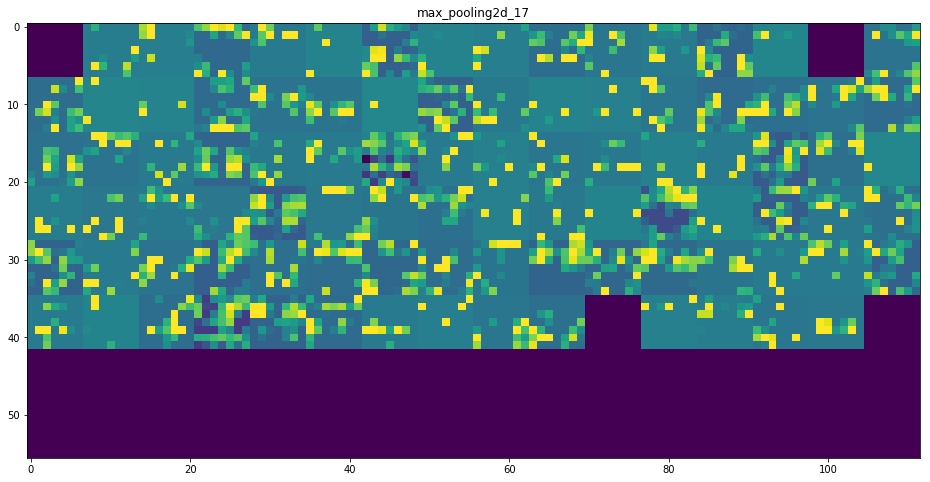

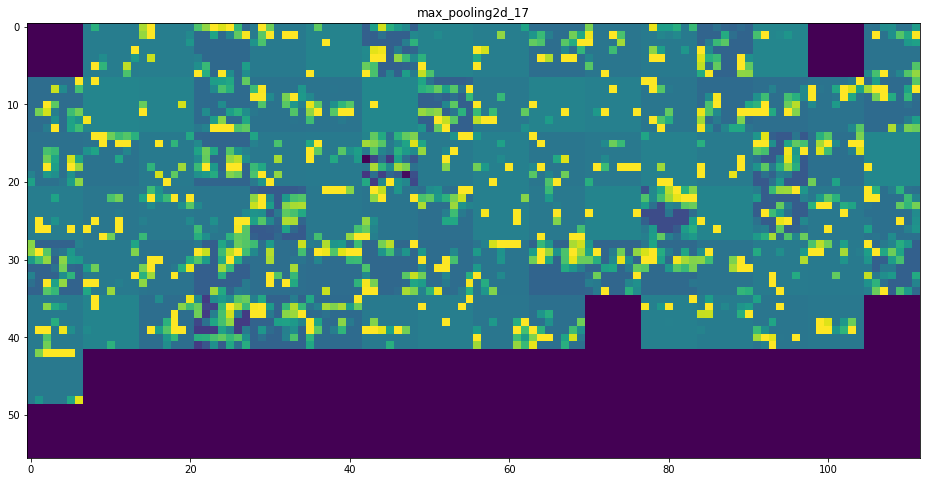

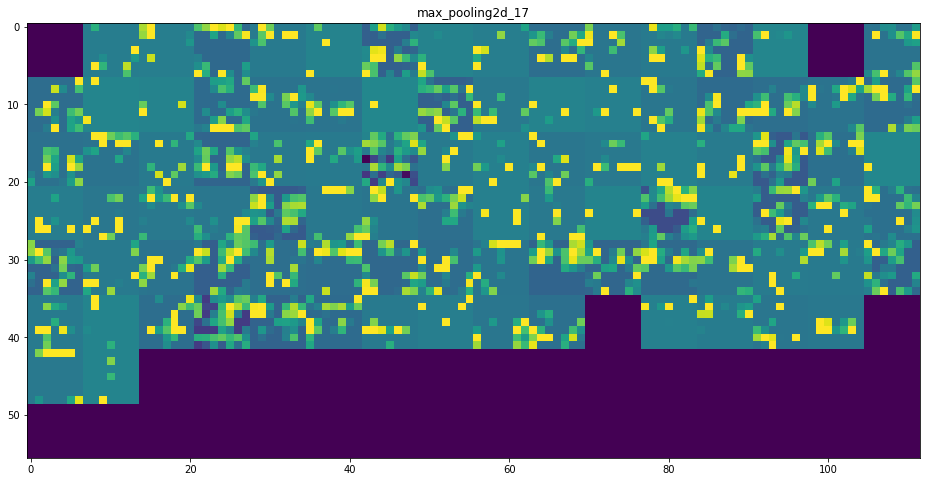

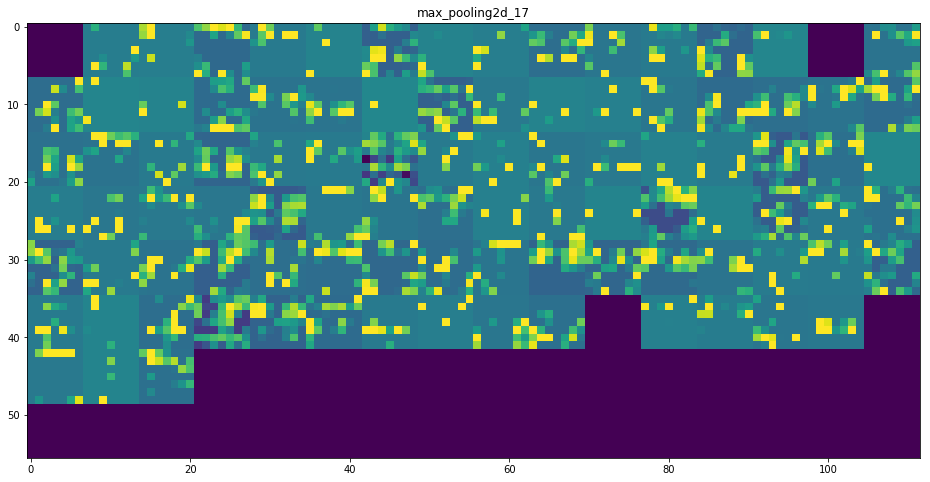

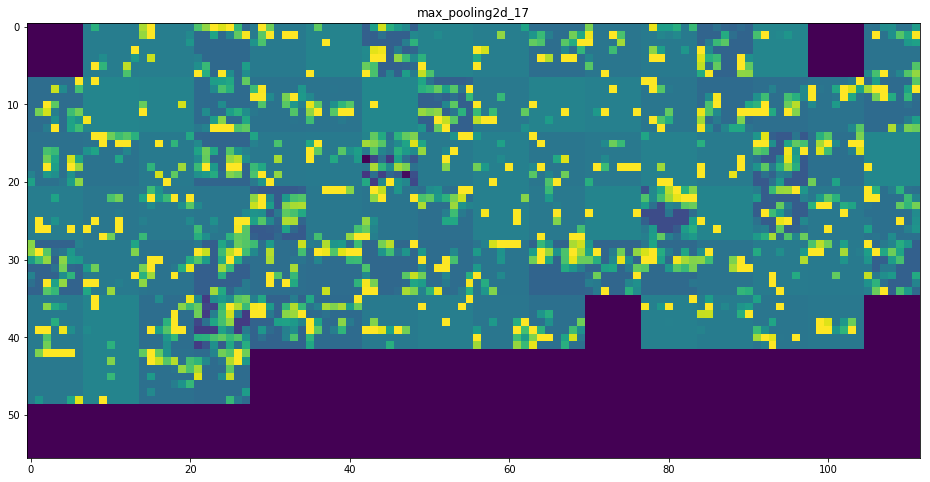

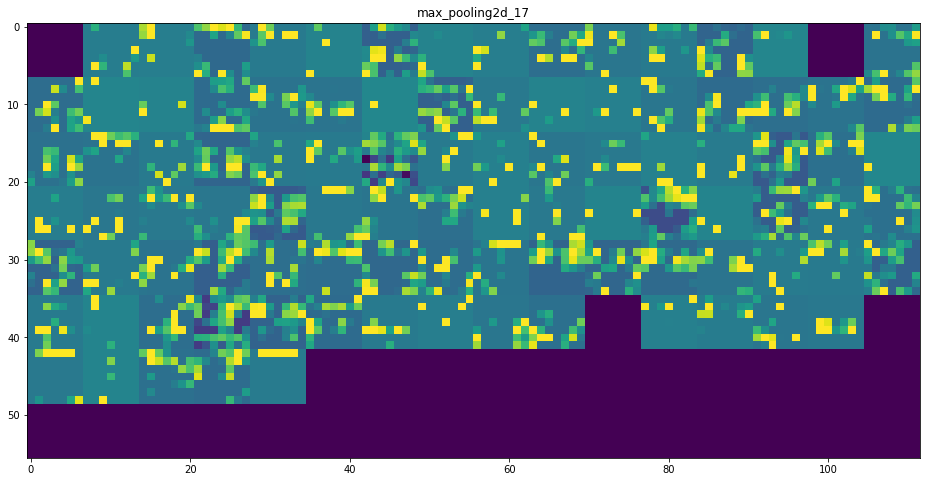

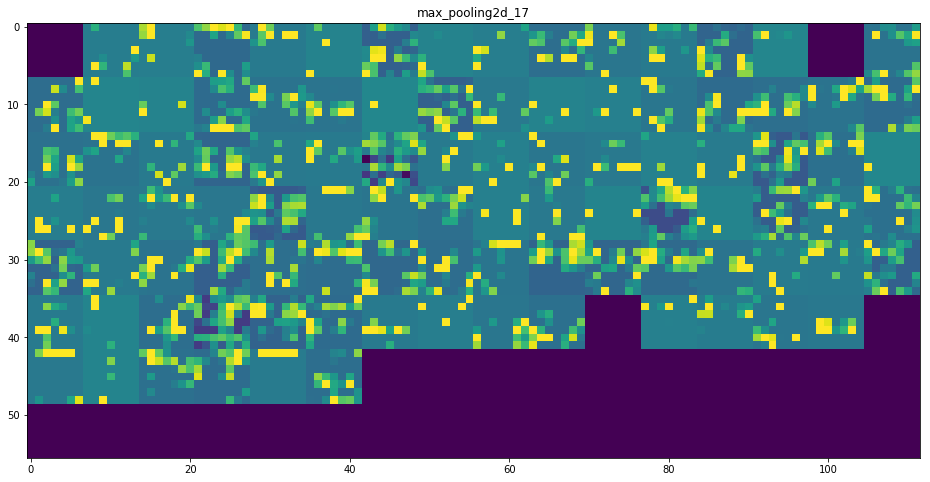

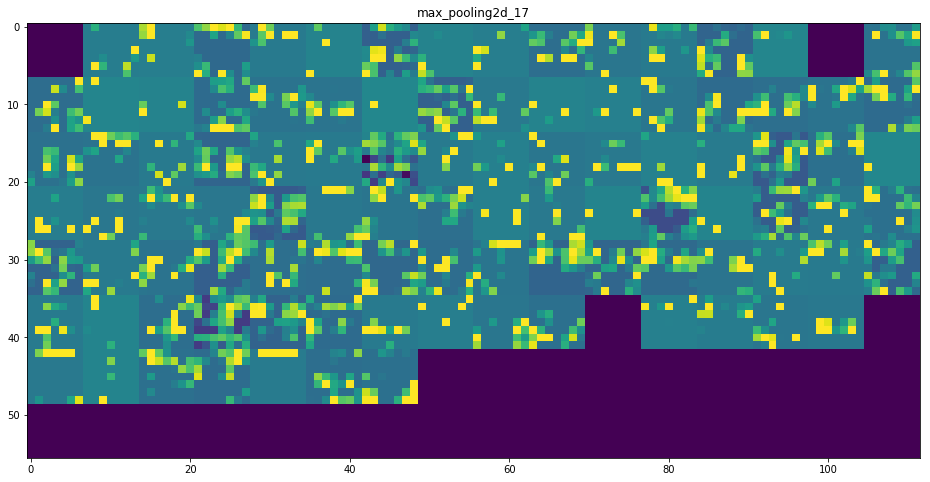

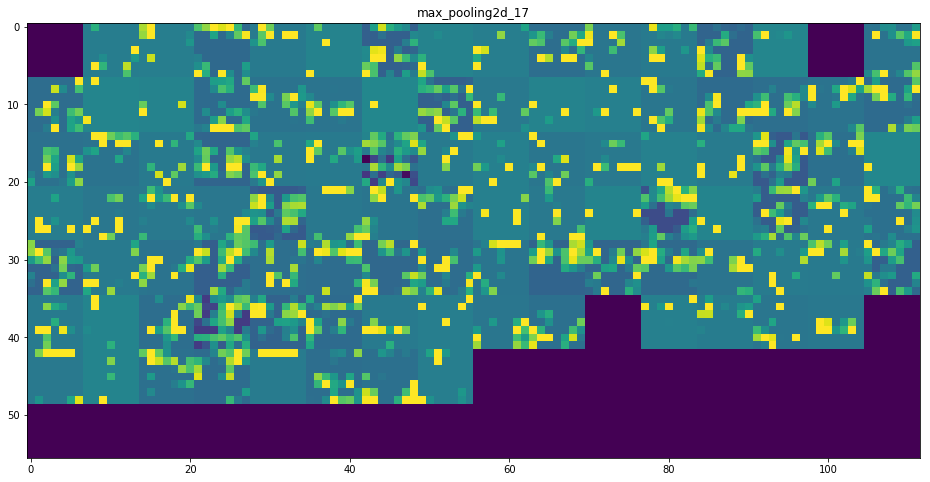

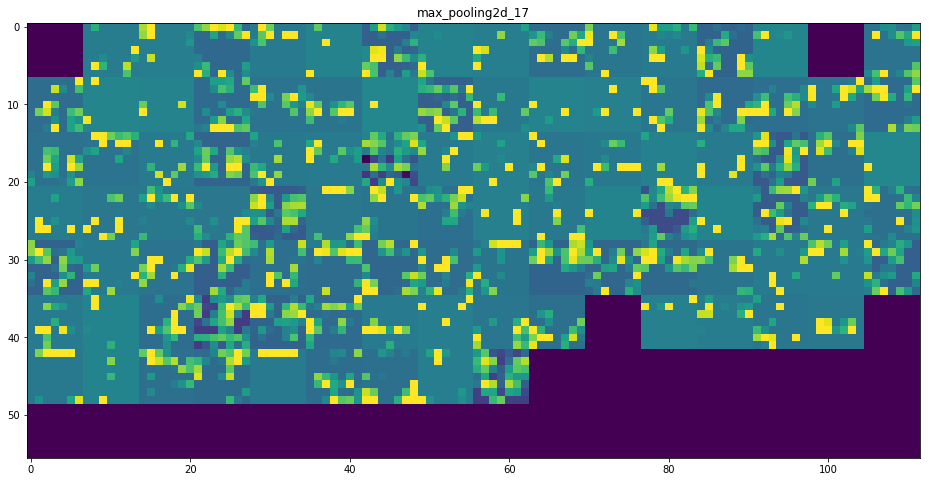

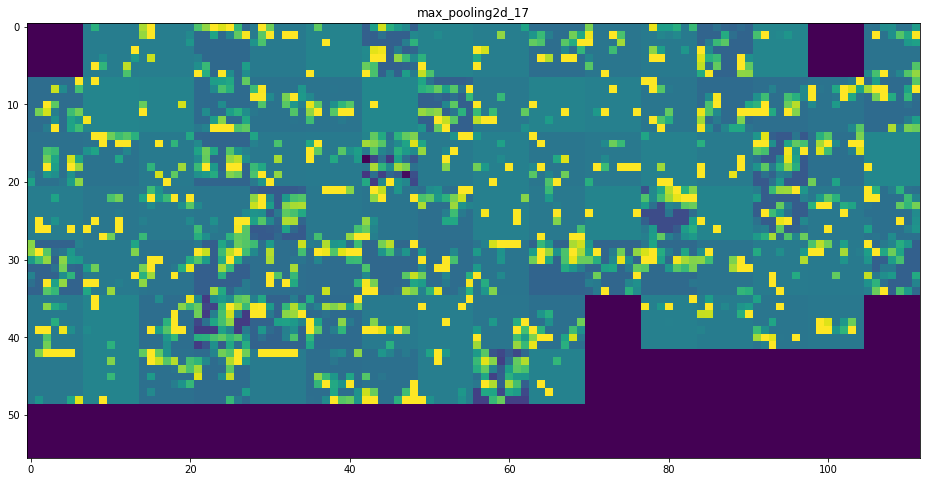

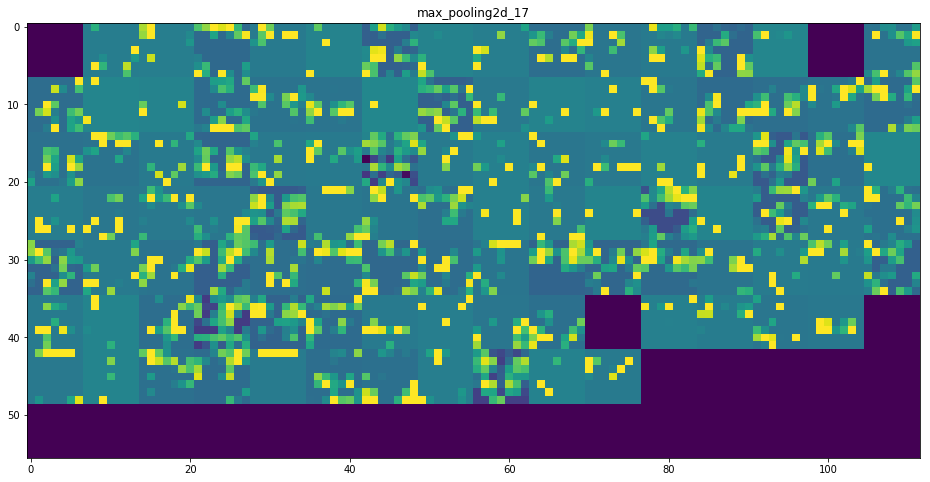

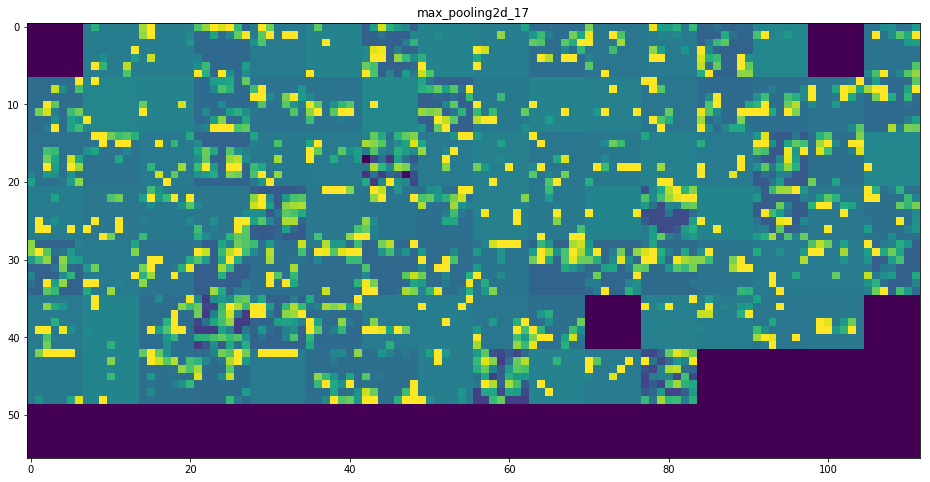

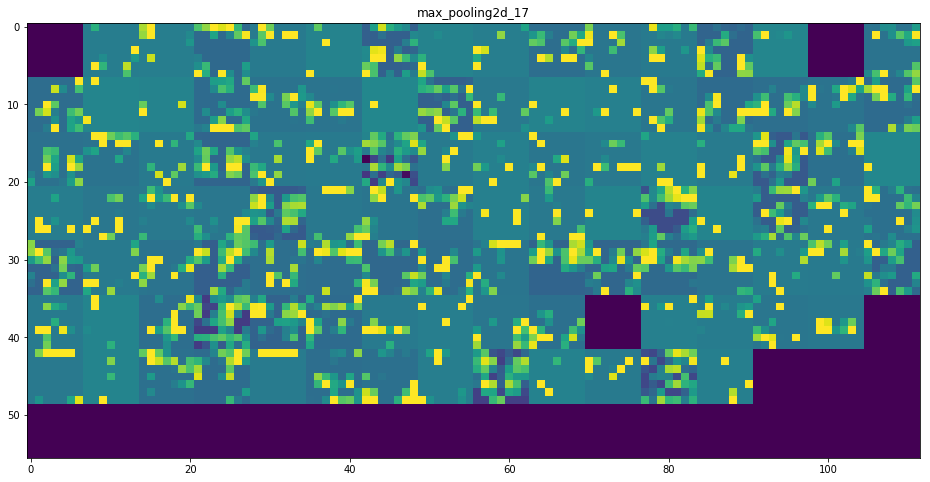

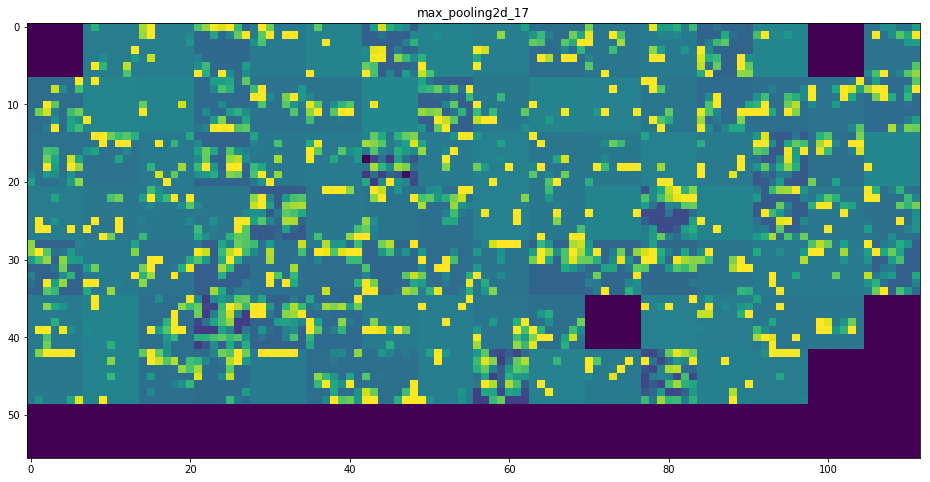

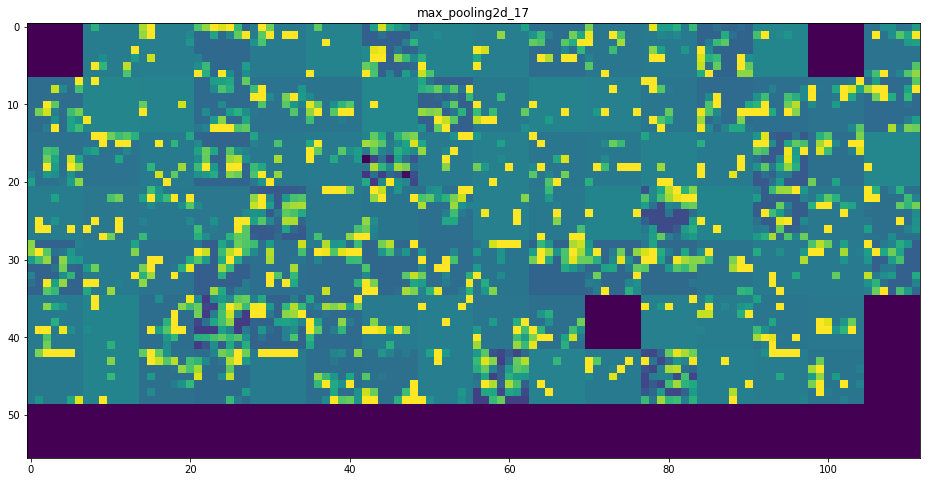

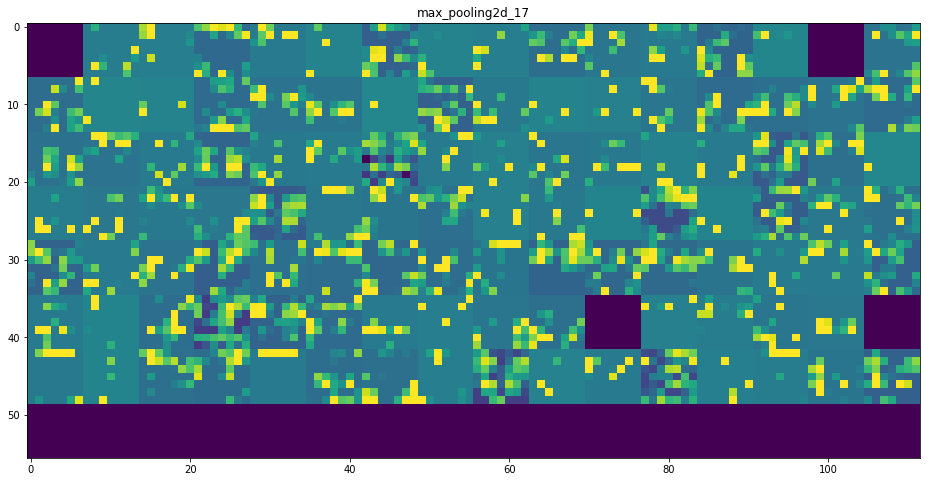

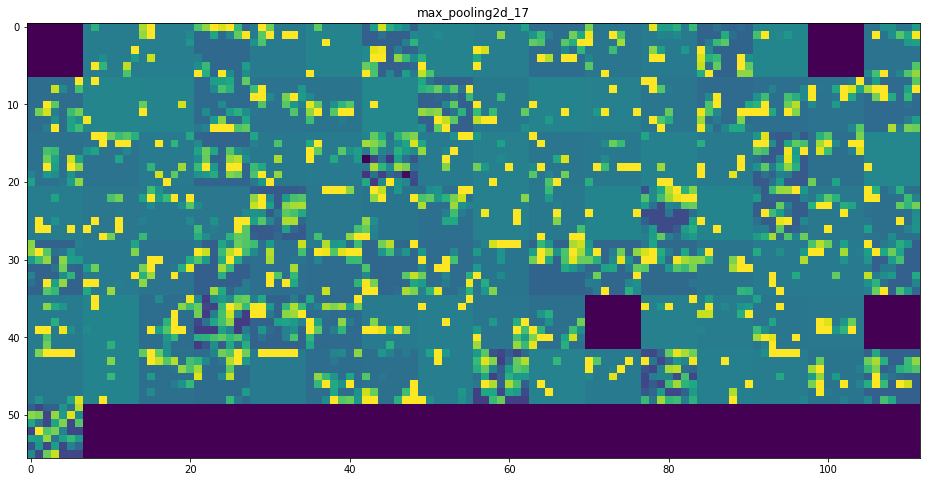

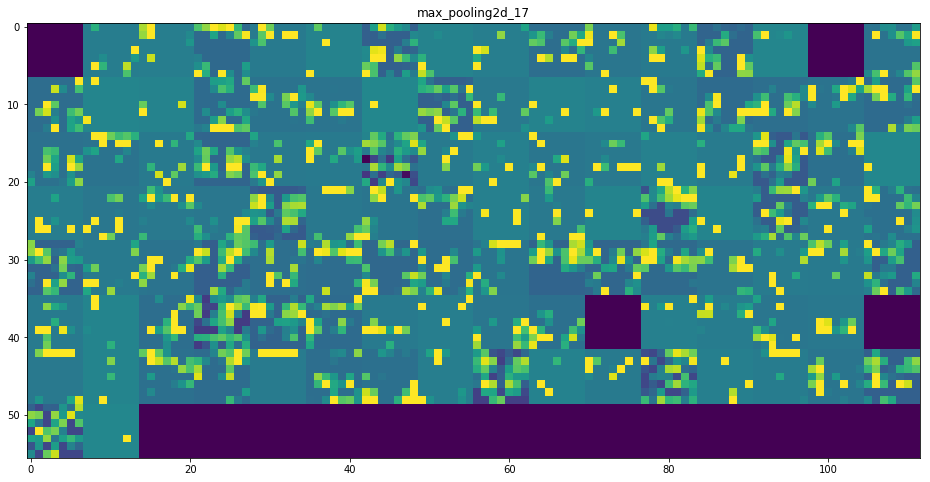

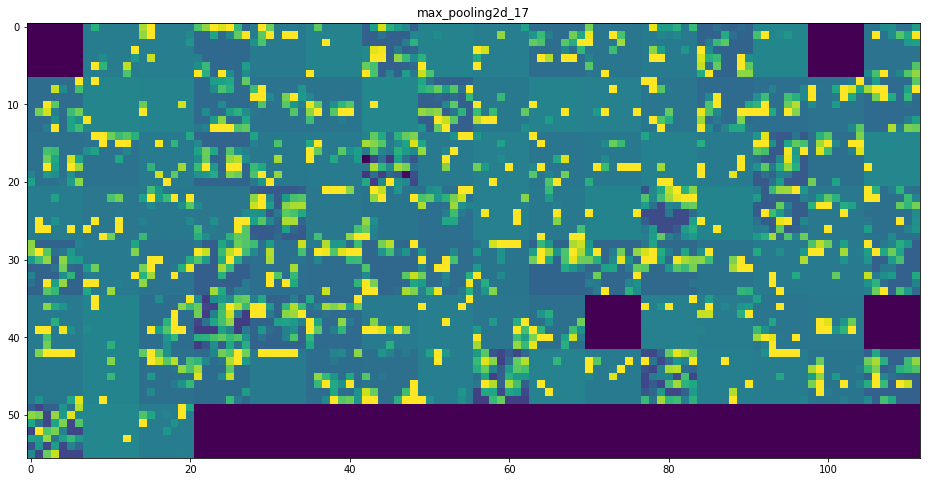

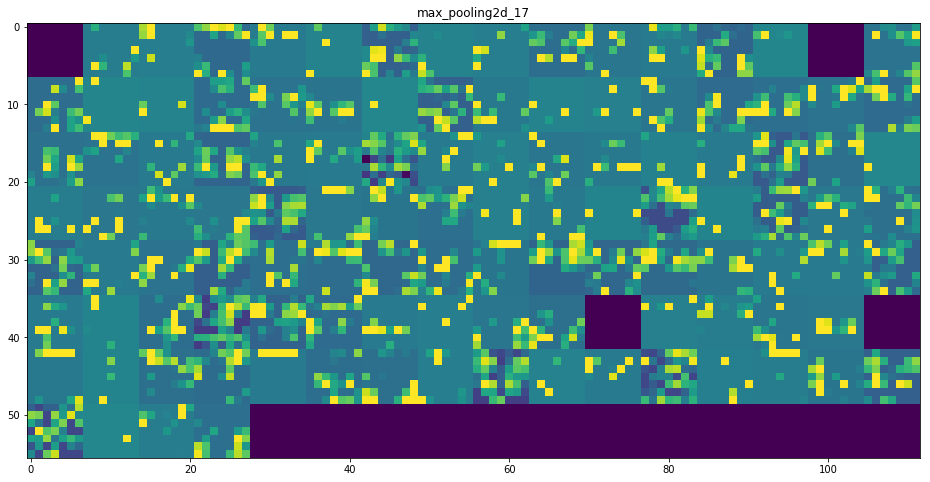

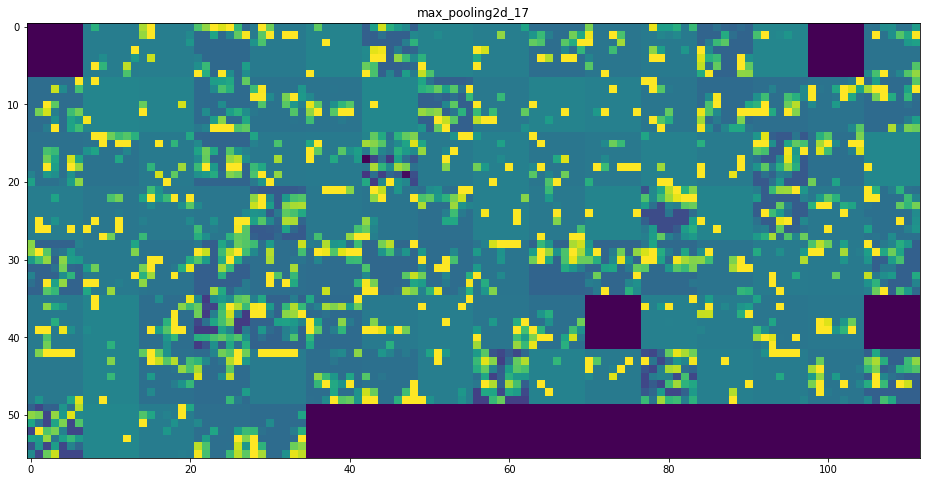

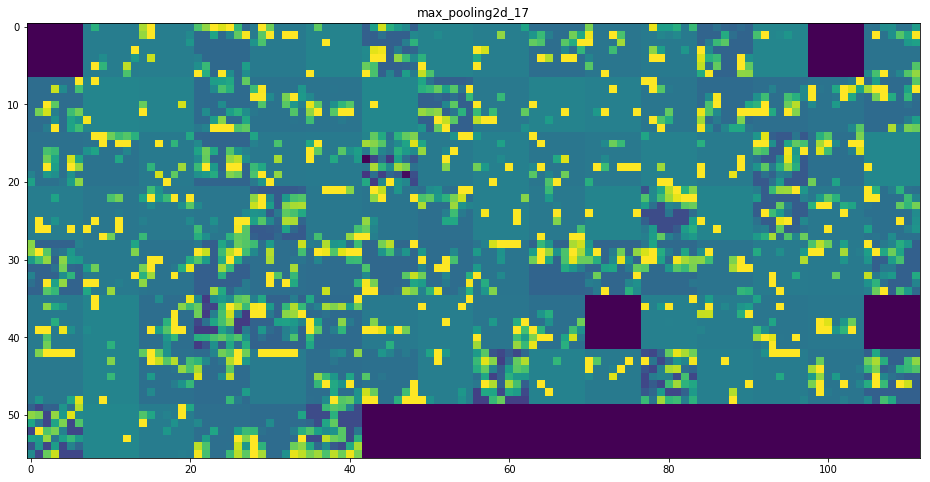

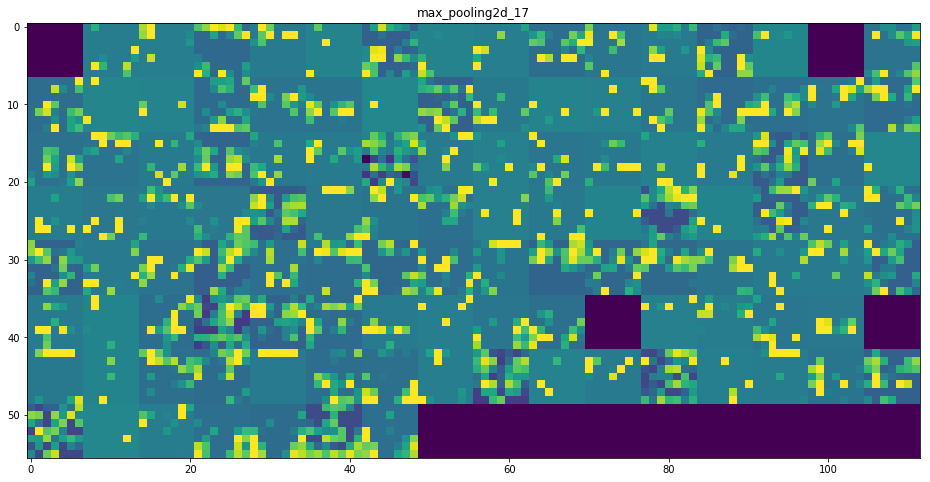

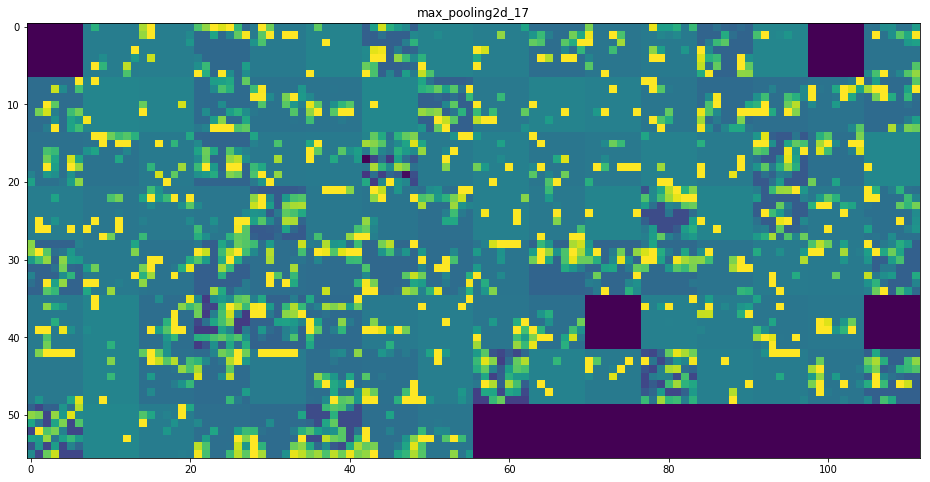

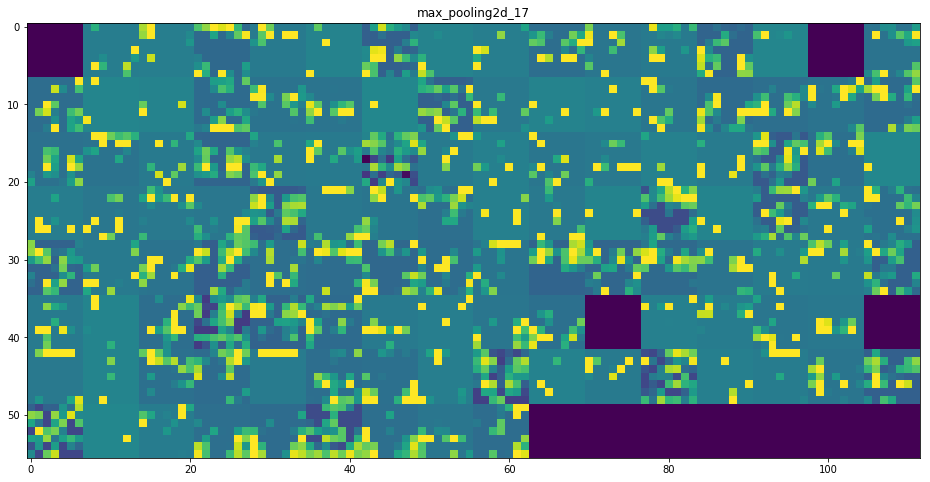

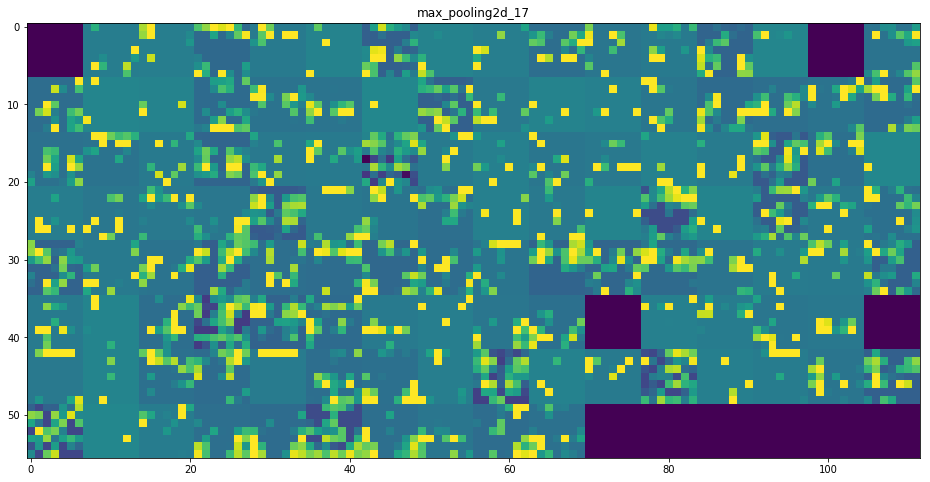

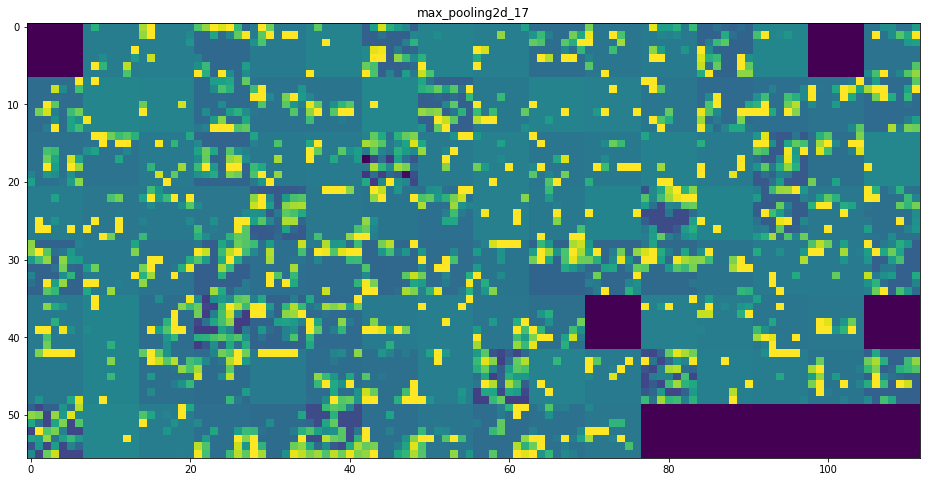

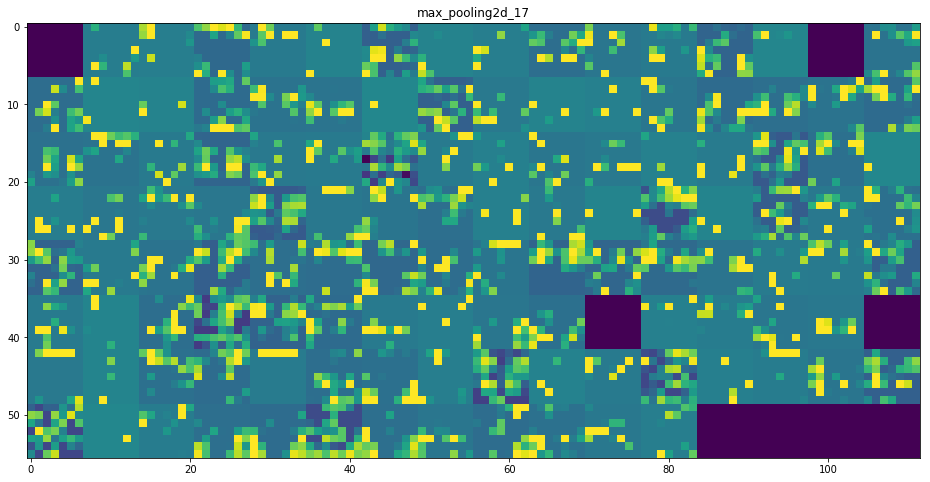

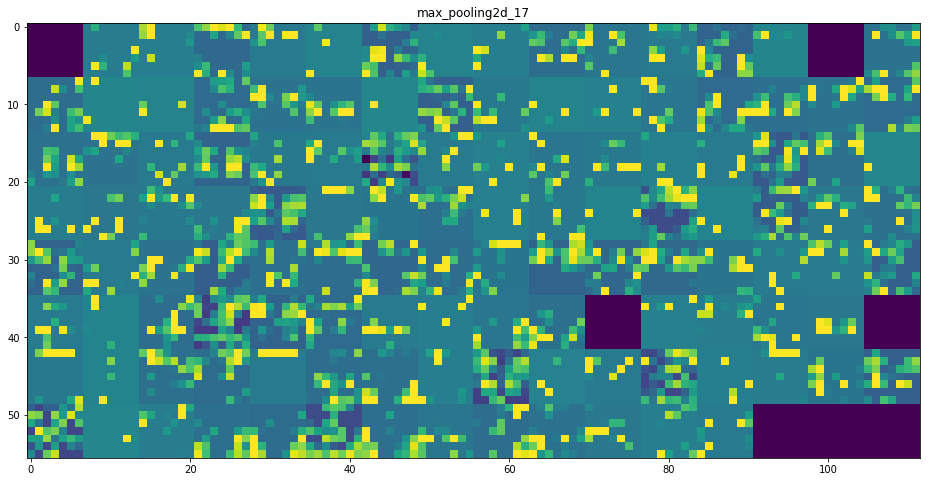

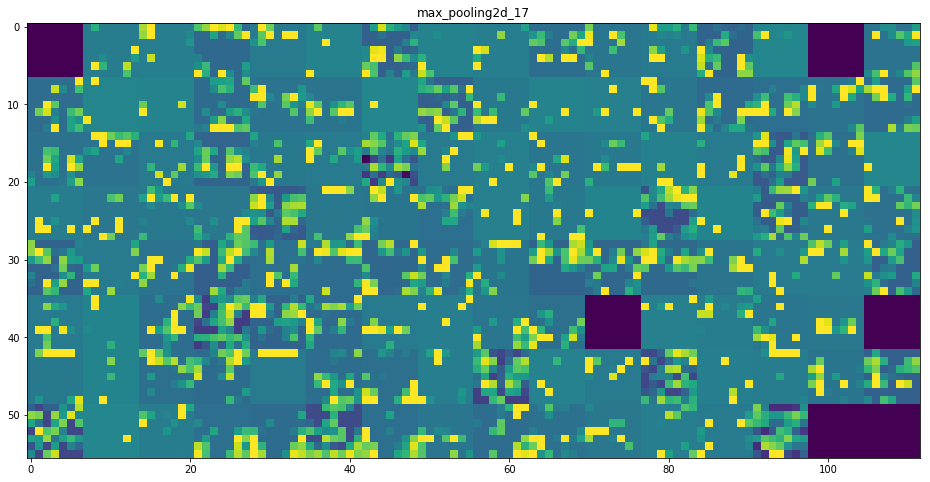

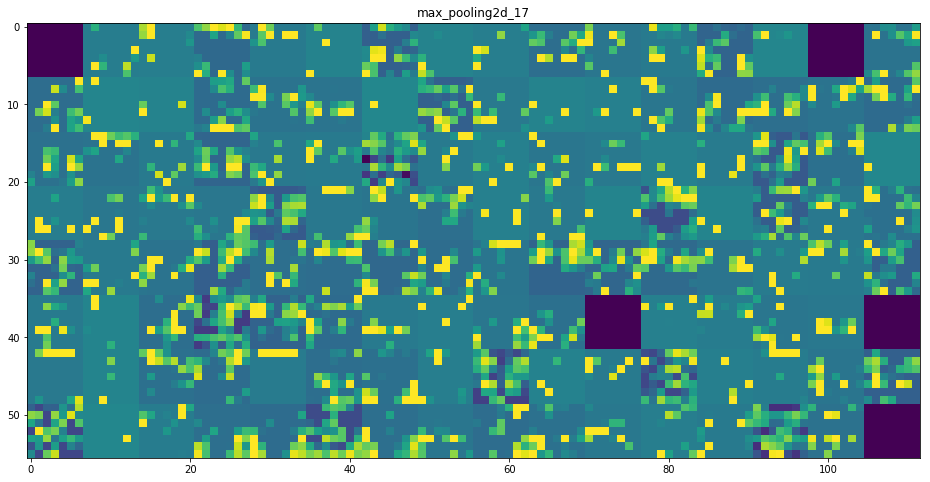

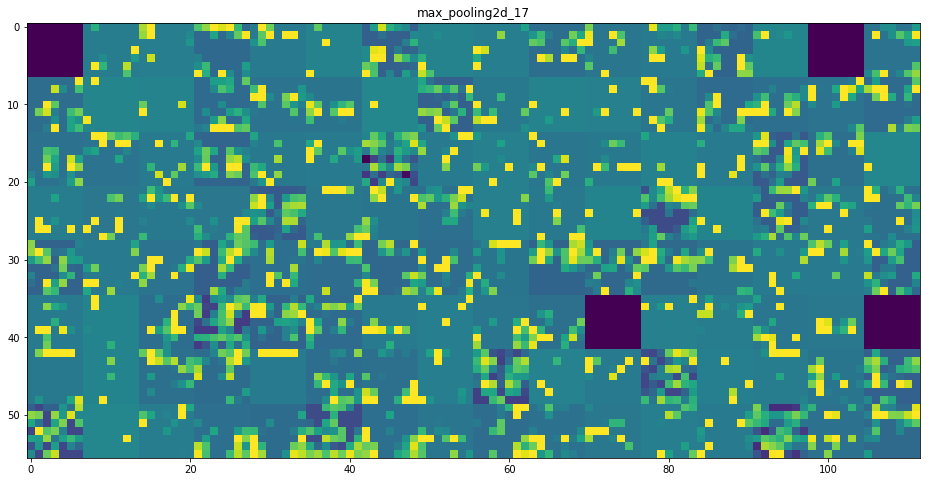

In [31]:
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)
    
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    
    size = layer_activation.shape[1]
    
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

for col in range(n_cols):
    for row in range(images_per_row):
        channel_image = layer_activation[0,
            :, :,
        col * images_per_row + row]
        
        channel_image -= channel_image.mean()
        channel_image /= channel_image.std()
        channel_image *= 64
        channel_image += 128
        channel_image = np.clip(channel_image, 0, 255).astype('uint8')
        display_grid[col * size : (col + 1) * size,
        row * size : (row + 1) * size] = channel_image
        
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
            scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

在激活层的结果中，值得注意的是：随着层数加深，激活变得越来越抽象，也即开始表示更高层次的概念。层数越深，其中表示关于视觉的信息就越少，关于类别的信息要越多。

激活的稀疏度sparsity随层数加深而增大。在后面的层中，越来越多的activations是空白的，也即输入图像中并未检测到这些filters所编码的模式。

#### 5.4.2 Visualizing convnet filters

想要观察卷积神经网络学到的过滤器，另一种简单的方法是显示每个过滤器所响应的视觉模式。这可以通过在输入空间中进行梯度上升来实现：从空白输入图像开始，将梯度下降应用于卷积神经网络输入图像的值，其目的是让某个过滤器的响应最大化。得到的输入图像是选定过滤器具有最大响应的图像。

接着，我们只需要构建一个loss，loss越小，图像在该filter上的activation越高：

In [32]:
from keras.applications import VGG16
from keras import backend as K

model = VGG16(weights='imagenet',
              include_top=False)

layer_name = 'block3_conv1'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:,:,:,filter_index])

In [33]:
grads = K.gradients(loss, model.input)[0]

用Keras的backend模块内置的gradients函数，我们可以得到loss相对于input的梯度。为了让梯度下降过程顺利进行，一个trick是将梯度张量除以其L2范数来标准化，这保证了输入图像的更新大小始终位于相同的范围。

In [34]:
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

我们需要一种方法:给定输入图像，它能够计算loss张量和gradient张量。我们需要用Keras后端的function函数定义iterate函数，它可以将一个Numpy张量转换为两个Numpy张量组成的列表，分别是loss和梯度。

In [35]:
iterate = K.function([model.input], [loss, grads])

import numpy as np
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

In [36]:
input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128

step = 1
for i in range(40):
    loss_value, grads_value = iterate([input_img_data])
    
    input_img_data += grads_value * step

通过40次的gradient ascent，我们就将一张随机的noise图转化为了在filter上activation最高的图。下面通过如下的函数将张量转化为有效的图像并显示：

In [37]:
def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    
    x += 0.5
    x = np.clip(x, 0, 1)
    
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [38]:
def generate_pattern(layer_name, filter_index, size=150):
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])
    
    grads = K.gradients(loss, model.input)[0]
    
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    
    iterate = K.function([model.input], [loss, grads])
    
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128
    
    step = 1
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return deprocess_image(img)

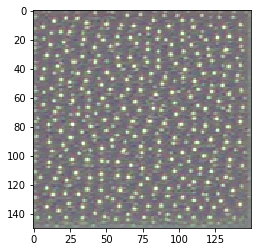

In [41]:
plt.imshow(generate_pattern('block3_conv1', 0))

如上图所示，block3_conv1层第0个filter响应的是波尔卡图案。下面我们将每一层前64个filters可视化：

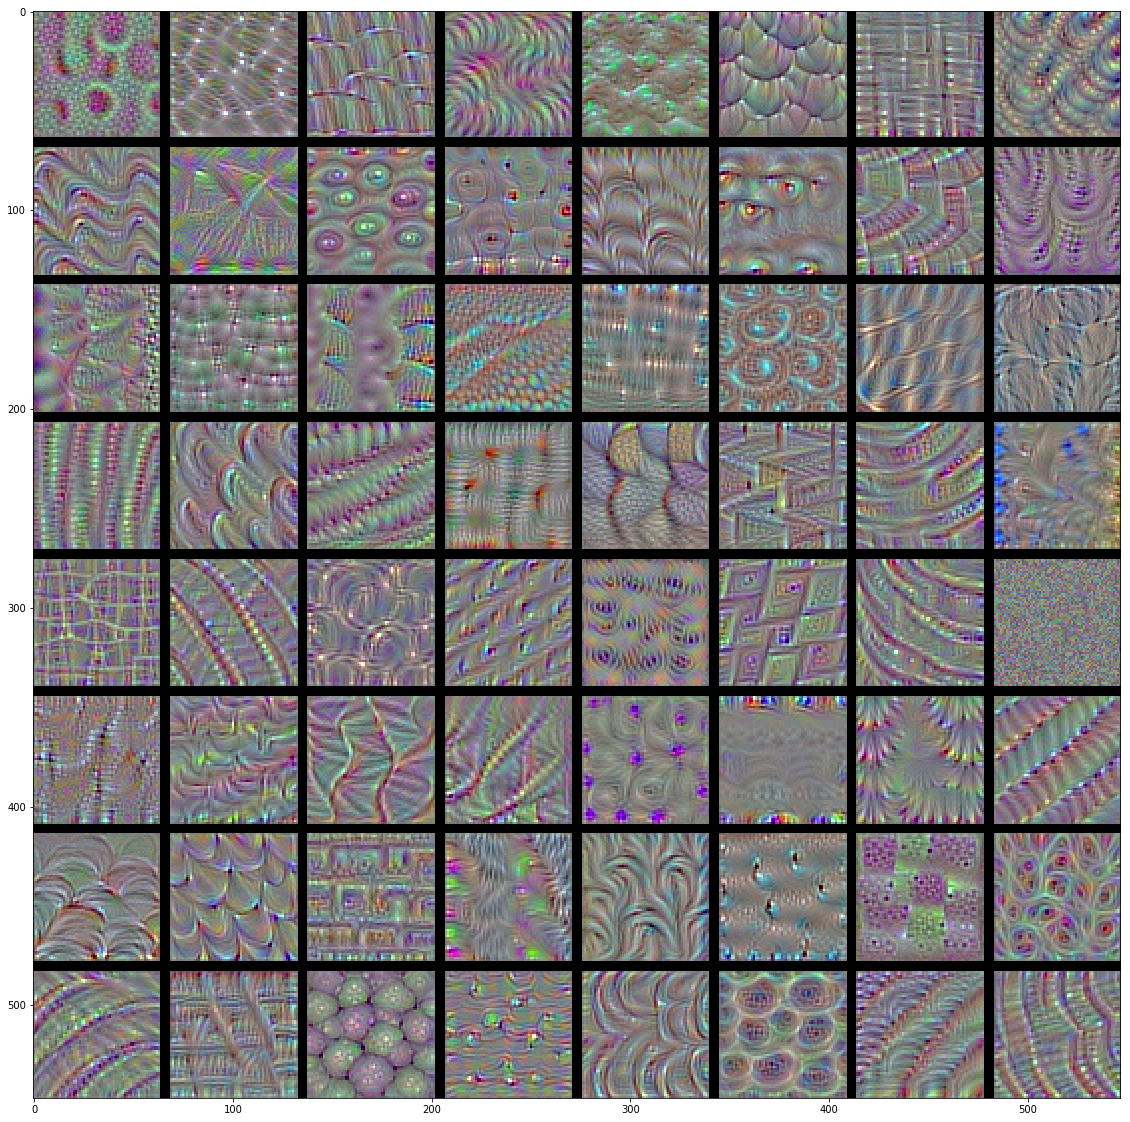

In [44]:
layer_name = 'block4_conv1'
size = 64
margin = 5

results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

for i in range(8):
    for j in range(8):
        filter_img = generate_pattern(layer_name, i + (j * 8), size=size)

        horizontal_start = i * size + i * margin
        horizontal_end = horizontal_start + size
        vertical_start = j * size + j * margin
        vertical_end = vertical_start + size
        results[horizontal_start: horizontal_end,
            vertical_start: vertical_end, :] = filter_img

results /= 255.
plt.figure(figsize=(20, 20))
plt.imshow(results)

可以修改上个cell中layer_name查看不同layer的filter模式，可以看出模型的第一层过滤器对应的只是简单的方向边缘、颜色，而block2_conv1对应的是简单纹理，更高层的filter对应的类似于自然图像中的纹理。

#### 5.4.3 Visualizing heatmaps of class activation

这种可视化方法有助于了解一张图像的**哪一部分**让convnet做出最终的分类决策，这有助于对convnet的决策过程进程调试。

这种通用技术叫做类激活图(CAM, class activation map)可视化。它是指对输入图像生成类激活的热力图。类激活热力图是与特定输出类别相关的二维分数网格，对任何输入图像的每个位置都要进行计算，它表示每个位置对该类别的重要程度。

我们使用的是“Grad-CAM: visual explanations from deep networks via gradientbased localization”这篇论文中的方法。该方法给定一张输入图像，对于一个卷积层的输出特征图，用类别相对于通道的梯度对这个特征图中的每个通道进行加权。直观上来看，理解这个技巧的一种方法是，你是用“每个通道对类别的重要程度”对“输入图像对不同通道的激活强度”的空间图进行加权，从而得到了“输入图像对类别的激活强度”的空间图。